In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch

from sklearn.metrics import (
    
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    balanced_accuracy_score, 
    classification_report,
    roc_auc_score,
    f1_score, 
    roc_curve
   
)

from hydra import compose, initialize
from omegaconf import OmegaConf, DictConfig

pd.options.mode.chained_assignment = None

with initialize(version_base=None, config_path="conf", job_name="test"):
    cfg = compose(config_name="config")
    print(OmegaConf.to_yaml(cfg))

random_seed: 0
work_dir: /work/robinpark
root_dir: ${work_dir}/AutoLabelClassifier
raw_dicom_folder: ${work_dir}/data-apr23/PID010A
clean_path: ${work_dir}/PID010A_clean
updated_clean_path: ${work_dir}/NCIMI_clean
unpaired_reports: /work/rhydian/ProcessedSpinalMRIReports/
model_weights_save_path: /work/robinpark/from_nfs2/models
osc_reports: ${work_dir}/AutoLabelClassifier/data/osclmric_reports
patient_metadata: ${clean_path}/patient_metadata.csv
conclusion_training_data: ${clean_path}/segmented_unpaired_reports_sum_no_len_limit.csv
train_labeled_data: ${updated_clean_path}/ncimi_sampled_test_set_labeled.csv
labeled_data: ${updated_clean_path}/ncimi_sampled_train_set_labeled.csv
no_hist_labeled_data: ${updated_clean_path}/ncimi_sampled_train_set_labeled.csv
full_ncimi_data: ${updated_clean_path}/unique_reports.csv
seg_full_ncimi_data: ${updated_clean_path}/segmented_unique_reports.csv
osc_train_data: ${osc_reports}/osclmric_reports_labeled_train.csv
osc_test_data: ${osc_reports}/osclmr

In [2]:
def norm_scores_yes(row):
    scores = torch.tensor([row['yes_score'], row['no_score']])
    return F.softmax(scores,dim=0)[0].item()

def norm_scores_no(row):
    scores = torch.tensor([row['yes_score'], row['no_score']])
    return F.softmax(scores,dim=0)[1].item()

In [3]:
li_results = []

In [4]:
def eval_global(model, desc, filepath, threshold=None):

    data_path = '/work/robinpark/AutoLabelClassifier/data'

    folder = f'{data_path}/report_labels'

    # Import results
    df_results = pd.read_csv(f'{folder}/{filepath}.csv', index_col=0).reset_index(drop=True)
    if 'labels' in df_results.columns:
        df_results = df_results.drop(columns=['labels'])

    if filepath.find('gpt') > -1:
        df_results.loc[df_results['results'].str.lower().str.find('uncertain') > -1, 'results'] = 0
        df_results.loc[df_results['results'].str.lower().str.find('yes') > -1, 'results'] = 1 
        df_results.loc[df_results['results'].str.lower().str.find('no') > -1, 'results'] = 0 
        df_results['results'] = df_results['results'].astype(int)

    if filepath.find('cancer') > -1:
        if filepath.find('cancer_TRAIN') > -1:
            df_true_labels = pd.read_csv(cfg.train_labeled_data, index_col=0).reset_index(drop=True)
        else:
            df_true_labels = pd.read_csv(cfg.labeled_data, index_col=0).reset_index(drop=True)
        df_results = df_results.merge(df_true_labels,left_index=True, right_index=True, how='left')
        df_results = df_results.rename(columns={'label':'labels'})
        display_labels = ['No Cancer','Cancer']
    
    if filepath.find('stenosis') > -1:
        if filepath.find('stenosis_TRAIN') > -1:
            df_true_labels = pd.read_csv(f'{data_path}/osclmric_reports/osclmric_reports_labeled_train.csv', index_col=0).reset_index(drop=True)
        else:
            df_true_labels = pd.read_csv(f'{data_path}/osclmric_reports/osclmric_reports_labeled_test.csv', index_col=0).reset_index(drop=True)
        df_results = df_results.merge(df_true_labels,left_index=True, right_index=True, how='left')
        df_results = df_results.loc[df_results.result > -1]
        df_results = df_results.rename(columns={'result':'labels'})
        display_labels = ['No Stenosis','Stenosis']

    if filepath.find('cauda_equina') > -1: 
        if filepath.find('cauda_equina_train') > -1:
            df_true_labels = pd.read_csv(f'{data_path}/osclmric_reports/manually_labeled_cauda_equina_train.csv', index_col=0).reset_index(drop=True)
        else:
            df_true_labels = pd.read_csv(f'{data_path}/osclmric_reports/manually_labeled_cauda_equina_test.csv', index_col=0).reset_index(drop=True)
        df_results = df_results.merge(df_true_labels,left_index=True, right_index=True, how='left')
        df_results = df_results.loc[df_results.global_label > -1]
        df_results = df_results.rename(columns={'global_label':'labels'})
        display_labels = ['No Cauda Equina','Cauda Equina']

    if filepath.find('spon') > -1: 
        if filepath.find('spon_train') > -1:
            df_true_labels = pd.read_csv(f'{data_path}/osclmric_reports/manually_labeled_spon_train.csv', index_col=0).reset_index(drop=True)
        else:
            df_true_labels = pd.read_csv(f'{data_path}/osclmric_reports/manually_labeled_spon_test.csv', index_col=0).reset_index(drop=True)
        df_results = df_results.merge(df_true_labels,left_index=True, right_index=True, how='left')
        df_results = df_results.loc[df_results.global_label > -1]
        df_results = df_results.rename(columns={'global_label':'labels'})
        display_labels = ['No Spon','Spondylolisthesis']

    if filepath.find('herniation') > -1: 
        if filepath.find('herniation_train') > -1:
            df_true_labels = pd.read_csv(f'{data_path}/osclmric_reports/herniation_reports_labeled_train.csv', index_col=0).reset_index(drop=True)
        else:
            df_true_labels = pd.read_csv(f'{data_path}/osclmric_reports/herniation_reports_labeled_test.csv', index_col=0).reset_index(drop=True)
        df_results = df_results.merge(df_true_labels,left_index=True, right_index=True, how='left')
        df_results = df_results.loc[df_results.global_label > -1]
        df_results = df_results.rename(columns={'global_label':'labels'})
        display_labels = ['No Herniation','Herniation']


    labels = df_results['labels']
    pred = df_results['results']

    roc_auc = '-'

    if model != 'gpt4':
        df_results['yes_norm'] = df_results.apply(lambda x: norm_scores_yes(x), axis=1)
        df_results['no_norm'] = df_results.apply(lambda x: norm_scores_no(x), axis=1)
        scores = df_results['yes_norm']

        if threshold:
            pred = df_results['yes_norm'] > threshold

        roc_auc = roc_auc_score(labels, scores)
        print(f'ROC AUC: {roc_auc}')

        fpr, tpr, threshold = roc_curve(labels, scores)
        fnr = 1 - tpr
        eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
        eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]

        print(f'EER threshold: {eer_threshold}')
        print(f'EER: {eer}')

    else:
        eer = '-'
    
    balanced_acc = balanced_accuracy_score(labels, pred)
    print(f'Balanced accuracy: {balanced_acc}')

    f1 = f1_score(labels, pred)
    print(f'F1 score: {f1}')

    class_report = classification_report(labels, pred, target_names=display_labels)
    conf_mat = confusion_matrix(labels, pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                display_labels=display_labels)

    print(class_report)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    if desc.find('test') > -1:
        li_results.append(
            {'model': model, 'desc': desc, 
            'balanced_accuracy': balanced_acc,
            'eer': eer,
            'auroc': roc_auc,
            'f1_score': f1}
        ) 
    
    return df_results

In [5]:
li_level_results = []

In [6]:
def eval_level(data, level, threshold=None): 

    label_path = '/work/robinpark/AutoLabelClassifier/data/report_labels/april2024/summary-query/base-base'
    root_path = '/work/robinpark/AutoLabelClassifier'

    level_rp = level.replace('-','')

    if data.find('stenosis') > -1:
        df_level = pd.read_csv(f'{label_path}/llama3_base_2step_{data}{level_rp}_new_template_yesno_scores_have_spec_summary_prompt.csv')
        df_newlabels = pd.read_csv(f'{root_path}/data/osclmric_reports/OSCLMRIC_reports_stenosis_by_ivd.csv')
        df_results = df_level.merge(df_newlabels, left_on='report_no_hist', right_on='Report', how='left')
        condition='stenosis'
        display_labels = ['No Stenosis','Stenosis']
    elif data.find('cauda_equina') > -1: 
        display_labels = ['No Cauda Equina','Cauda Equina']
        df_level = pd.read_csv(f'{label_path}/llama3_base_2step_{data}{level_rp}_new_template_yesno_scores_have_spec_summary_prompt.csv')
        condition='cauda_equina'
        if data.find('cauda_equina_train') > -1: 
            df_newlabels = pd.read_csv(f'{root_path}/data/osclmric_reports/manually_labeled_cauda_equina_train.csv')
        elif data.find('cauda_equina_test') > -1:
            df_newlabels = pd.read_csv(f'{root_path}/data/osclmric_reports/manually_labeled_cauda_equina_test.csv')
        df_results = df_level.merge(df_newlabels, left_on='report_no_hist', right_on='report', how='left')
    elif data.find('spon') > -1: 
        display_labels = ['No Spon','Spondylolisthesis']
        df_level = pd.read_csv(f'{label_path}/llama3_base_2step_{data}{level_rp}_new_template_yesno_scores_have_spec_summary_prompt.csv')
        condition='spon'
        if data.find('spon_train') > -1: 
            df_newlabels = pd.read_csv(f'{root_path}/data/osclmric_reports/manually_labeled_spon_train.csv')
        elif data.find('spon_test') > -1:
            df_newlabels = pd.read_csv(f'{root_path}/data/osclmric_reports/manually_labeled_spon_test.csv')
        df_results = df_level.merge(df_newlabels, left_on='report_no_hist', right_on='report', how='left')
        df_results = df_results.loc[df_results[level]>-1]
    elif data.find('herniation') > -1: 
        display_labels = ['No Herniation','Herniation']
        df_level = pd.read_csv(f'{label_path}/llama3_base_2step_{data}{level_rp}_new_template_yesno_scores_have_spec_summary_prompt.csv')
        condition='herniation'
        if data.find('herniation_train') > -1: 
            df_newlabels = pd.read_csv(f'{root_path}/data/osclmric_reports/herniation_reports_labeled_train.csv')
        elif data.find('herniation_test') > -1:
            df_newlabels = pd.read_csv(f'{root_path}/data/osclmric_reports/herniation_reports_labeled_test.csv')
        df_results = df_level.merge(df_newlabels, left_on='report_no_hist', right_on='report', how='left')
        df_results = df_results.loc[df_results[level]>-1]
    
    df_results['labels'] = df_results[level].fillna(0)

    df_results['yes_norm'] = df_results.apply(lambda x: norm_scores_yes(x), axis=1)
    df_results['no_norm'] = df_results.apply(lambda x: norm_scores_no(x), axis=1)

    labels = df_results['labels']
    scores = df_results['yes_norm']
    pred = df_results['results']

    if threshold:
        pred = df_results['yes_norm'] > threshold
        
    roc_auc = roc_auc_score(labels, scores)
    print(f'ROC AUC: {roc_auc}')

    balanced_acc = balanced_accuracy_score(labels, pred)
    print(f'Balanced accuracy: {balanced_acc}')

    f1 = f1_score(labels, pred)
    print(f'F1 score: {f1}')

    fpr, tpr, threshold = roc_curve(labels, scores)
    fnr = 1 - tpr
    eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
    eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
    test = fnr[np.nanargmin(np.absolute((fnr - fpr)))]

    print(f'EER threshold: {eer_threshold}')
    print(f'EER: {eer}')

    class_report = classification_report(labels, pred, target_names=display_labels)
    conf_mat = confusion_matrix(labels, pred)

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,
                                display_labels=display_labels)

    print(class_report)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    if (data.find('TRAIN') > -1) | (data.find('cauda_equina_test') > -1) | (data.find('herniation_test') > -1) | (data.find('spon_test') > -1):
        li_level_results.append(
            {'condition': condition,
            'level': level, 
            'balanced_accuracy': balanced_acc,
            'eer': eer,
            'auroc': roc_auc,
            'f1_score': f1}
        ) 

    return df_results

## Global Results per Report

### GPT-4 Baseline

Balanced accuracy: 1.0
F1 score: 1.0
              precision    recall  f1-score   support

   No Cancer       1.00      1.00      1.00        78
      Cancer       1.00      1.00      1.00        67

    accuracy                           1.00       145
   macro avg       1.00      1.00      1.00       145
weighted avg       1.00      1.00      1.00       145



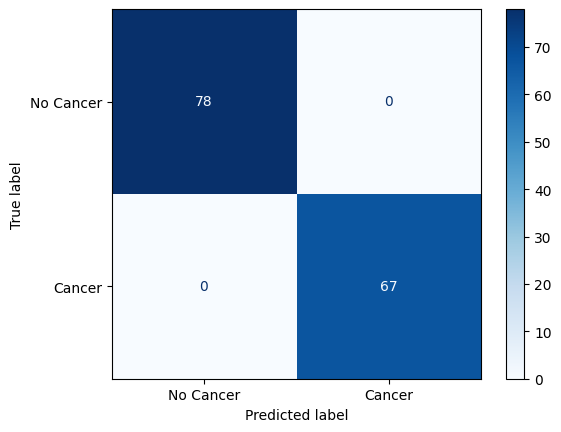

In [7]:
gpt_cancer_1step_test = eval_global(
    'gpt4', 
    'direct-query-cancer-test',
    'april2024/direct-query/gpt4_cancer_TRAIN_new_have_prompt', 
    threshold=None)    

Balanced accuracy: 0.9512195121951219
F1 score: 0.9487179487179488
              precision    recall  f1-score   support

 No Stenosis       0.87      1.00      0.93        27
    Stenosis       1.00      0.90      0.95        41

    accuracy                           0.94        68
   macro avg       0.94      0.95      0.94        68
weighted avg       0.95      0.94      0.94        68



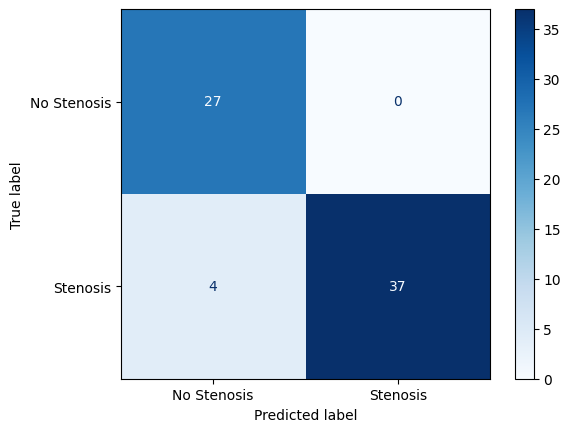

In [8]:
gpt_stenosis_1step_test = eval_global(
    'gpt4', 
    'direct-query-stenosis-test',
    'direct-query/gpt4_stenosis_TRAIN_new_have_prompt', 
    threshold=None)    

Balanced accuracy: 1.0
F1 score: 1.0
                 precision    recall  f1-score   support

No Cauda Equina       1.00      1.00      1.00        77
   Cauda Equina       1.00      1.00      1.00        17

       accuracy                           1.00        94
      macro avg       1.00      1.00      1.00        94
   weighted avg       1.00      1.00      1.00        94



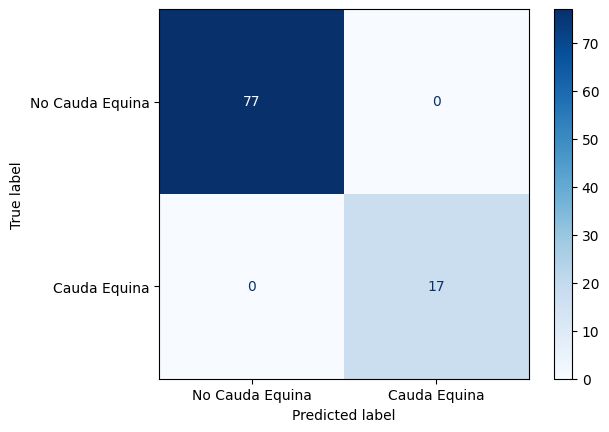

In [9]:
gpt_ce_1step_test = eval_global(
    'gpt4', 
    'direct-query-cauda-equina-test',
    'april2024/direct-query/gpt4_cauda_equina_test_new_have_prompt', 
    threshold=None)    

Balanced accuracy: 0.9345238095238095
F1 score: 0.9152542372881356
               precision    recall  f1-score   support

No Herniation       0.97      0.90      0.94        42
   Herniation       0.87      0.96      0.92        28

     accuracy                           0.93        70
    macro avg       0.92      0.93      0.93        70
 weighted avg       0.93      0.93      0.93        70



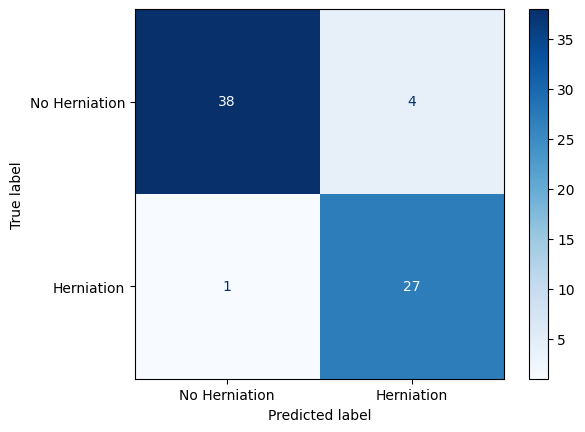

In [10]:
gpt_hern_1step_test = eval_global(
    'gpt4', 
    'direct-query-herniation-test',
    'april2024/direct-query/gpt4_herniation_test_new_have_prompt', 
    threshold=None)    

Balanced accuracy: 0.9736842105263157
F1 score: 0.972972972972973
                   precision    recall  f1-score   support

          No Spon       0.95      1.00      0.97        39
Spondylolisthesis       1.00      0.95      0.97        38

         accuracy                           0.97        77
        macro avg       0.98      0.97      0.97        77
     weighted avg       0.98      0.97      0.97        77



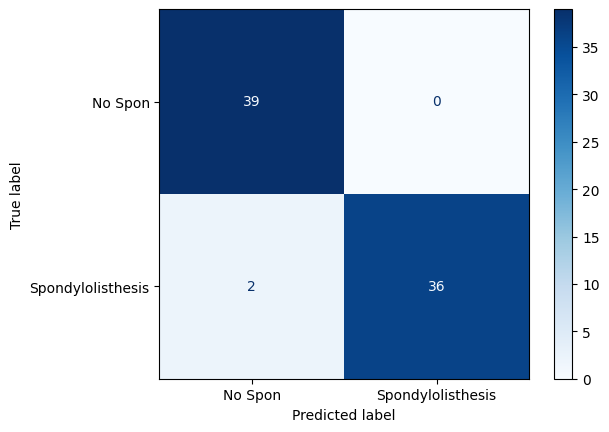

In [11]:
gpt_spon_1step_test = eval_global(
    'gpt4', 
    'direct-query-spon-test',
    'april2024/direct-query/gpt4_spon_test_new_have_prompt', 
    threshold=None)    

### One-Step Query

#### Zephyr

ROC AUC: 0.9934573706808424
EER threshold: 0.0002891702461056411
EER: 0.0136986301369863
Balanced accuracy: 0.9632999386628501
F1 score: 0.9618320610687023
              precision    recall  f1-score   support

   No Cancer       0.95      0.99      0.97        73
      Cancer       0.98      0.94      0.96        67

    accuracy                           0.96       140
   macro avg       0.97      0.96      0.96       140
weighted avg       0.97      0.96      0.96       140



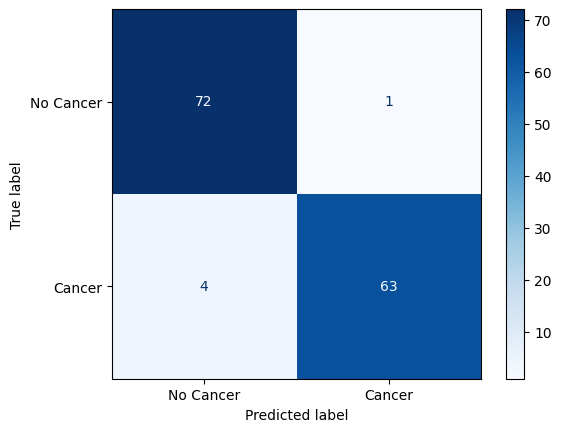

In [12]:
zephyr_1step_cancer_train = eval_global(
    'zephyr', 
    'direct-query-cancer-train', 
    'april2024/direct-query/zephyr_base_1step_cancer_new_template_yesno_scores_have_prompt', 
    threshold=None
    )

ROC AUC: 1.0
EER threshold: 5.4455751524074e-05
EER: 0.0
Balanced accuracy: 0.9925373134328358
F1 score: 0.9924812030075187
              precision    recall  f1-score   support

   No Cancer       0.99      1.00      0.99        78
      Cancer       1.00      0.99      0.99        67

    accuracy                           0.99       145
   macro avg       0.99      0.99      0.99       145
weighted avg       0.99      0.99      0.99       145



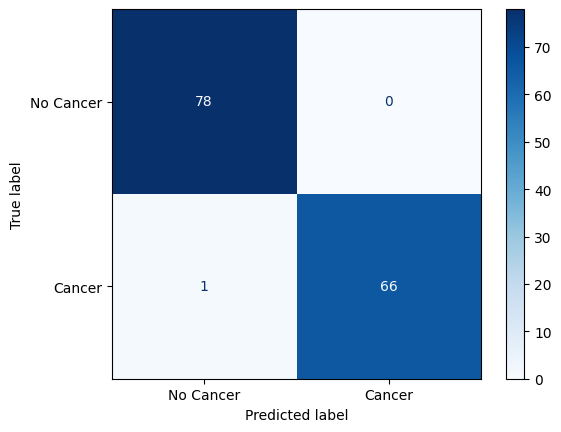

In [13]:
zephyr_1step_cancer_test = eval_global(
    'zephyr', 
    'direct-query-cancer-test', 
    'april2024/direct-query/zephyr_base_1step_cancer_TRAIN_new_template_yesno_scores_have_prompt', 
    threshold=0.0002891702461056411
    )

ROC AUC: 0.9565217391304348
EER threshold: 2.4696184482309036e-05
EER: 0.08695652173913043
Balanced accuracy: 0.8338164251207729
F1 score: 0.8205128205128205
              precision    recall  f1-score   support

 No Stenosis       0.63      0.96      0.76        23
    Stenosis       0.97      0.71      0.82        45

    accuracy                           0.79        68
   macro avg       0.80      0.83      0.79        68
weighted avg       0.85      0.79      0.80        68



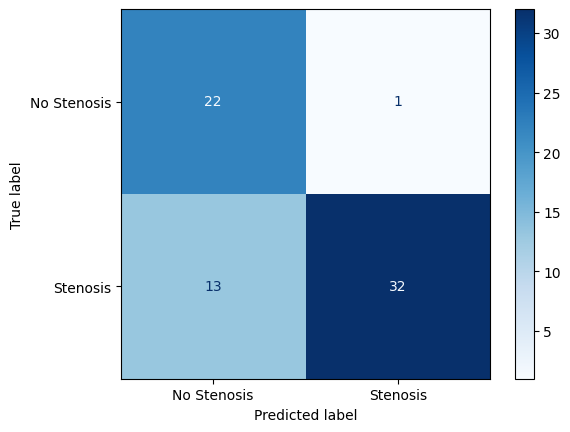

In [14]:
zephyr_1step_stenosis_train = eval_global(
    'zephyr', 
    'direct-query-stenosis-train',
    'april2024/direct-query/zephyr_base_1step_stenosis_new_template_yesno_scores_have_prompt', 
    threshold=None
    )

ROC AUC: 0.981029810298103
EER threshold: 2.619749238874647e-06
EER: 0.037037037037037035
Balanced accuracy: 0.9448961156278229
F1 score: 0.9500000000000001
              precision    recall  f1-score   support

 No Stenosis       0.90      0.96      0.93        27
    Stenosis       0.97      0.93      0.95        41

    accuracy                           0.94        68
   macro avg       0.94      0.94      0.94        68
weighted avg       0.94      0.94      0.94        68



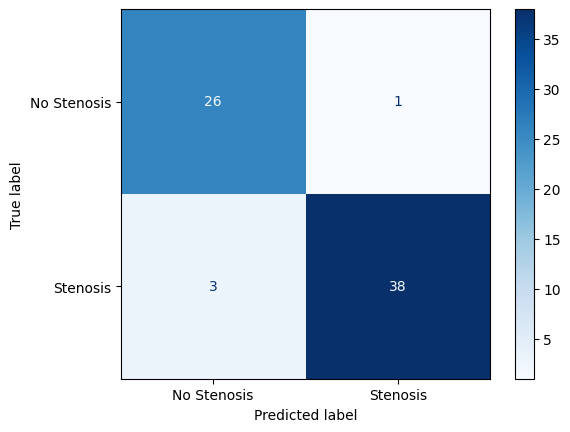

In [15]:
zephyr_1step_stenosis_test = eval_global(
    'zephyr', 
    'direct-query-stenosis-test',
    'april2024/direct-query/zephyr_base_1step_stenosis_TRAIN_new_template_yesno_scores_have_prompt', 
    threshold=2.4696184482309036e-05
    )

ROC AUC: 0.9890350877192984
EER threshold: 1.855737423284154e-06
EER: 0.013157894736842105
Balanced accuracy: 0.6878654970760234
F1 score: 0.5384615384615385
                 precision    recall  f1-score   support

No Cauda Equina       0.87      0.99      0.93        76
   Cauda Equina       0.88      0.39      0.54        18

       accuracy                           0.87        94
      macro avg       0.87      0.69      0.73        94
   weighted avg       0.87      0.87      0.85        94



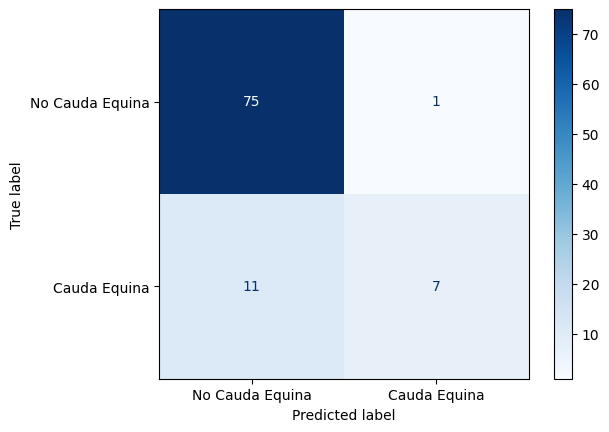

In [16]:
zephyr_1step_ce_train = eval_global(
    'zephyr', 
    'direct-query-cauda-equina-train',
    'april2024/direct-query/zephyr_base_1step_cauda_equina_train_new_template_yesno_scores_have_prompt', 
    threshold=None
    )

ROC AUC: 0.9717341482047365
EER threshold: 6.314601250778651e-07
EER: 0.012987012987012988
Balanced accuracy: 0.9117647058823529
F1 score: 0.9032258064516129
                 precision    recall  f1-score   support

No Cauda Equina       0.96      1.00      0.98        77
   Cauda Equina       1.00      0.82      0.90        17

       accuracy                           0.97        94
      macro avg       0.98      0.91      0.94        94
   weighted avg       0.97      0.97      0.97        94



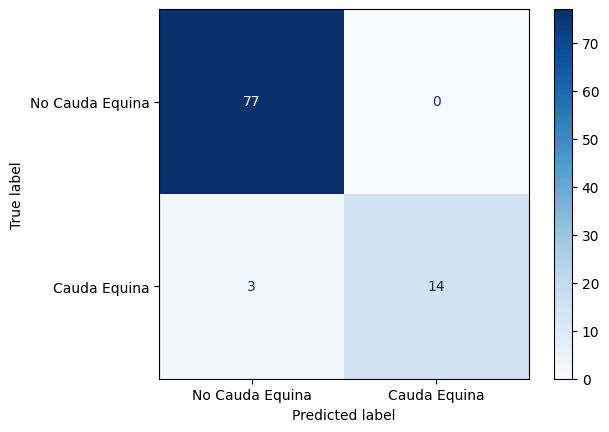

In [17]:
zephyr_1step_ce_test = eval_global(
    'zephyr', 
    'direct-query-cauda-equina-test',
    'april2024/direct-query/zephyr_base_1step_cauda_equina_test_new_template_yesno_scores_have_prompt', 
    threshold=1.855737423284154e-06
    )

ROC AUC: 0.8818027210884354
EER threshold: 0.9585765600204468
EER: 0.21428571428571427
Balanced accuracy: 0.8333333333333334
F1 score: 0.7999999999999999
               precision    recall  f1-score   support

No Herniation       0.94      0.74      0.83        42
   Herniation       0.70      0.93      0.80        28

     accuracy                           0.81        70
    macro avg       0.82      0.83      0.81        70
 weighted avg       0.84      0.81      0.82        70



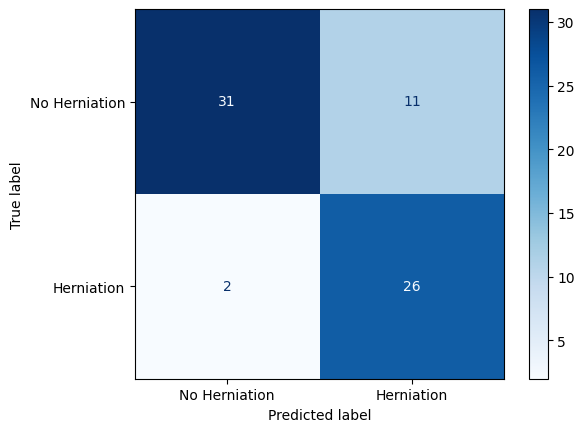

In [18]:
zephyr_1step_hern_train = eval_global(
    'zephyr', 
    'direct-query-hern-train',
    'april2024/direct-query/zephyr_base_1step_herniation_train_new_template_yesno_scores_have_prompt', 
    threshold=None
    )

ROC AUC: 0.9468537414965987
EER threshold: 0.9020277261734009
EER: 0.11904761904761904
Balanced accuracy: 0.8690476190476191
F1 score: 0.8421052631578947
               precision    recall  f1-score   support

No Herniation       0.90      0.88      0.89        42
   Herniation       0.83      0.86      0.84        28

     accuracy                           0.87        70
    macro avg       0.87      0.87      0.87        70
 weighted avg       0.87      0.87      0.87        70



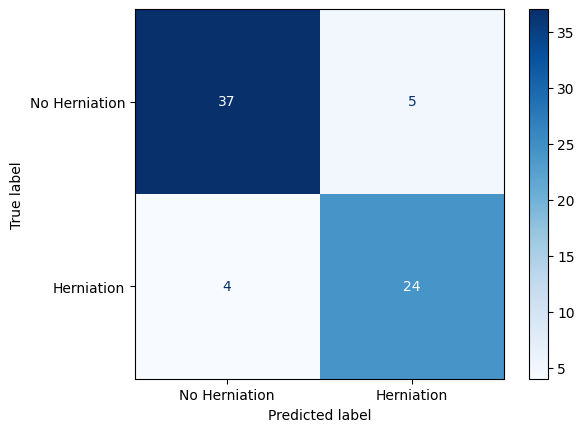

In [19]:
zephyr_1step_hern_test = eval_global(
    'zephyr', 
    'direct-query-hern-test',
    'april2024/direct-query/zephyr_base_1step_herniation_test_new_template_yesno_scores_have_prompt', 
    threshold=0.9585765600204468
    )

ROC AUC: 0.9548978153629316
EER threshold: 2.7750988010666333e-05
EER: 0.06976744186046512
Balanced accuracy: 0.897463002114165
F1 score: 0.8852459016393442
                   precision    recall  f1-score   support

          No Spon       0.88      0.98      0.92        43
Spondylolisthesis       0.96      0.82      0.89        33

         accuracy                           0.91        76
        macro avg       0.92      0.90      0.90        76
     weighted avg       0.91      0.91      0.91        76



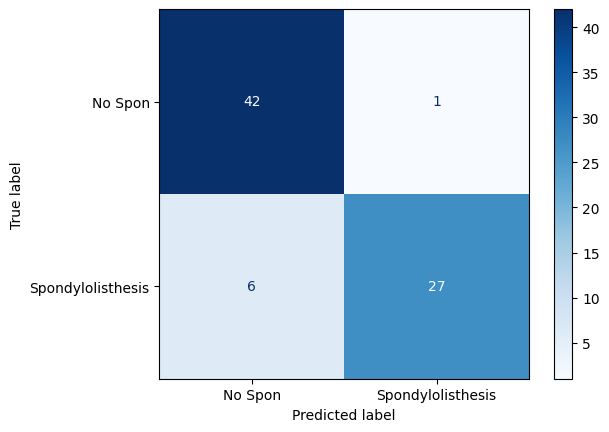

In [20]:
zephyr_1step_ce_train = eval_global(
    'zephyr', 
    'direct-query-spon-train',
    'april2024/direct-query/zephyr_base_1step_spon_train_new_template_yesno_scores_have_prompt', 
    threshold=None
    )

ROC AUC: 0.9959514170040485
EER threshold: 2.5224288037861697e-05
EER: 0.02564102564102564
Balanced accuracy: 0.9740215924426451
F1 score: 0.9736842105263158
                   precision    recall  f1-score   support

          No Spon       0.97      0.97      0.97        39
Spondylolisthesis       0.97      0.97      0.97        38

         accuracy                           0.97        77
        macro avg       0.97      0.97      0.97        77
     weighted avg       0.97      0.97      0.97        77



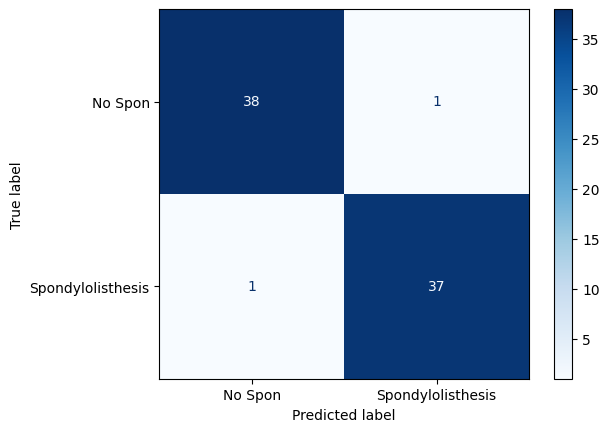

In [21]:
zephyr_1step_ce_test = eval_global(
    'zephyr', 
    'direct-query-spon-test',
    'april2024/direct-query/zephyr_base_1step_spon_test_new_template_yesno_scores_have_prompt', 
    threshold=2.7750988010666333e-05
    )

#### Llama3

ROC AUC: 0.998773257002658
EER threshold: 0.9889054298400879
EER: 0.0136986301369863
Balanced accuracy: 0.9719893682273564
F1 score: 0.9705882352941176
              precision    recall  f1-score   support

   No Cancer       0.99      0.96      0.97        73
      Cancer       0.96      0.99      0.97        67

    accuracy                           0.97       140
   macro avg       0.97      0.97      0.97       140
weighted avg       0.97      0.97      0.97       140



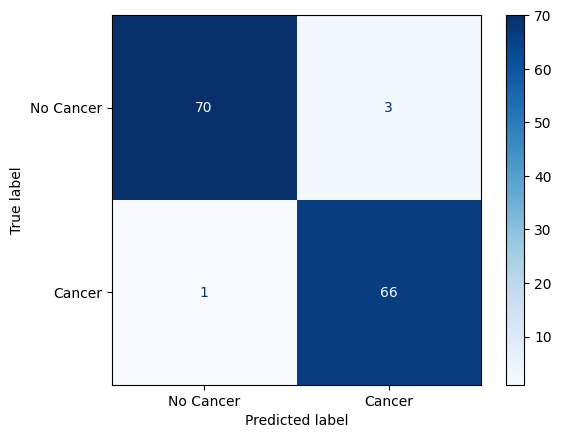

In [22]:
llama3_1step_cancer_train = eval_global(
    'llama3', 
    'direct-query-cancer-train', 
    'april2024/direct-query/llama3_base_1step_cancer_new_template_yesno_scores_have_prompt', 
    threshold=None
    )

ROC AUC: 0.998773257002658
EER threshold: 0.9889054298400879
EER: 0.0136986301369863
Balanced accuracy: 0.9782253117971784
F1 score: 0.9774436090225564
              precision    recall  f1-score   support

   No Cancer       0.97      0.99      0.98        73
      Cancer       0.98      0.97      0.98        67

    accuracy                           0.98       140
   macro avg       0.98      0.98      0.98       140
weighted avg       0.98      0.98      0.98       140



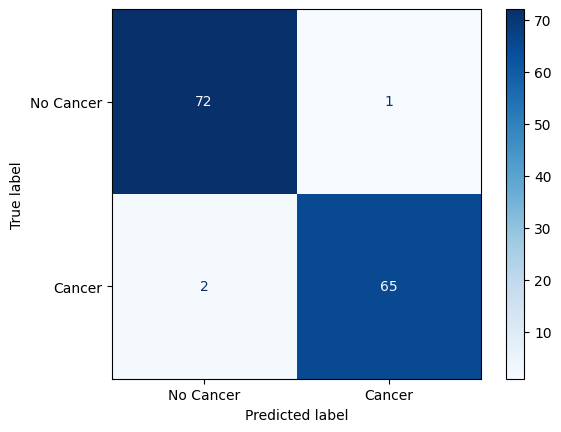

In [23]:
llama3_1step_cancer_test = eval_global(
    'llama3', 
    'direct-query-cancer-test', 
    'april2024/direct-query/llama3_base_1step_cancer_new_template_yesno_scores_have_prompt', 
    threshold=0.9889054298400879
    )

ROC AUC: 0.9845410628019323
EER threshold: 0.9768972396850586
EER: 0.0
Balanced accuracy: 0.9014492753623189
F1 score: 0.9333333333333333
              precision    recall  f1-score   support

 No Stenosis       0.87      0.87      0.87        23
    Stenosis       0.93      0.93      0.93        45

    accuracy                           0.91        68
   macro avg       0.90      0.90      0.90        68
weighted avg       0.91      0.91      0.91        68



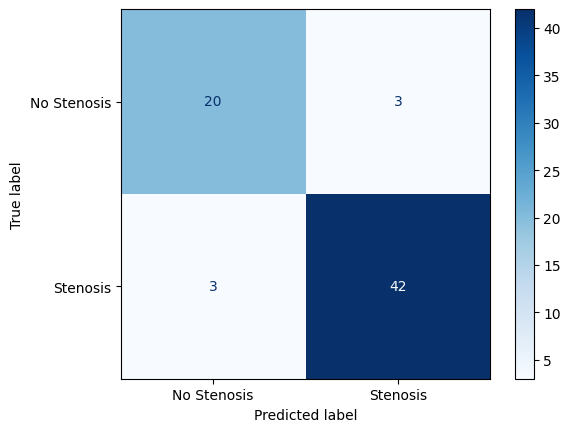

In [24]:
llama3_1step_stenosis_train = eval_global(
    'llama3', 
    'direct-query-stenosis-train', 
    'april2024/direct-query/llama3_base_1step_stenosis_new_template_yesno_scores_have_prompt', 
    threshold=None
    )

ROC AUC: 0.987353206865402
EER threshold: 0.9791182279586792
EER: 0.0
Balanced accuracy: 0.9634146341463414
F1 score: 0.9620253164556963
              precision    recall  f1-score   support

 No Stenosis       0.90      1.00      0.95        27
    Stenosis       1.00      0.93      0.96        41

    accuracy                           0.96        68
   macro avg       0.95      0.96      0.95        68
weighted avg       0.96      0.96      0.96        68



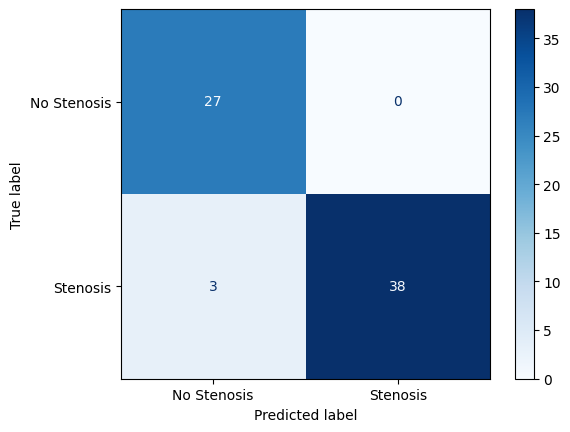

In [25]:
llama3_1step_stenosis_test = eval_global(
    'llama3', 
    'direct-query-stenosis-test', 
    'april2024/direct-query/llama3_base_1step_stenosis_TRAIN_new_template_yesno_scores_have_prompt', 
    threshold=0.9768972396850586
    )

ROC AUC: 0.9919590643274854
EER threshold: 0.9670377969741821
EER: 0.013157894736842105
Balanced accuracy: 0.993421052631579
F1 score: 0.972972972972973
                 precision    recall  f1-score   support

No Cauda Equina       1.00      0.99      0.99        76
   Cauda Equina       0.95      1.00      0.97        18

       accuracy                           0.99        94
      macro avg       0.97      0.99      0.98        94
   weighted avg       0.99      0.99      0.99        94



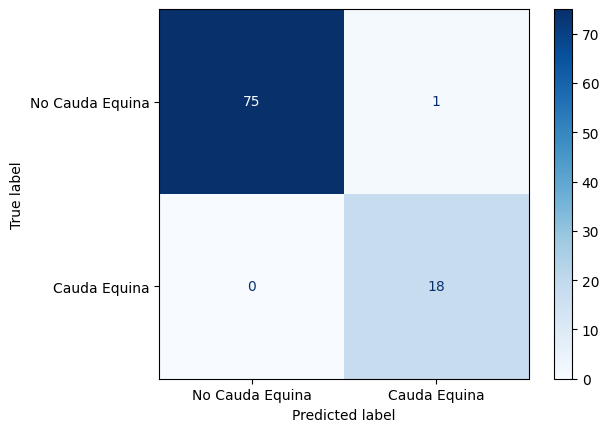

In [26]:
llama3_1step_ce_train = eval_global(
    'llama3', 
    'direct-query-cauda-equina-train',
    'april2024/direct-query/llama3_base_1step_cauda_equina_train_new_template_yesno_scores_have_prompt', 
    threshold=None
    )

ROC AUC: 0.9977081741787625
EER threshold: 0.660459041595459
EER: 0.025974025974025976
Balanced accuracy: 0.9411764705882353
F1 score: 0.9375
                 precision    recall  f1-score   support

No Cauda Equina       0.97      1.00      0.99        77
   Cauda Equina       1.00      0.88      0.94        17

       accuracy                           0.98        94
      macro avg       0.99      0.94      0.96        94
   weighted avg       0.98      0.98      0.98        94



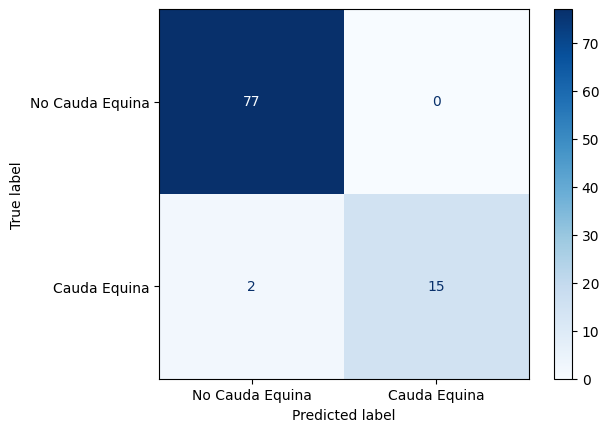

In [27]:
llama3_1step_ce_test = eval_global(
    'llama3', 
    'direct-query-cauda-equina-test',
    'april2024/direct-query/llama3_base_1step_cauda_equina_test_new_template_yesno_scores_have_prompt', 
    threshold=0.9670377969741821
    )

ROC AUC: 0.9795918367346939
EER threshold: 0.9915252327919006
EER: 0.07142857142857142
Balanced accuracy: 0.9404761904761905
F1 score: 0.9180327868852458
               precision    recall  f1-score   support

No Herniation       1.00      0.88      0.94        42
   Herniation       0.85      1.00      0.92        28

     accuracy                           0.93        70
    macro avg       0.92      0.94      0.93        70
 weighted avg       0.94      0.93      0.93        70



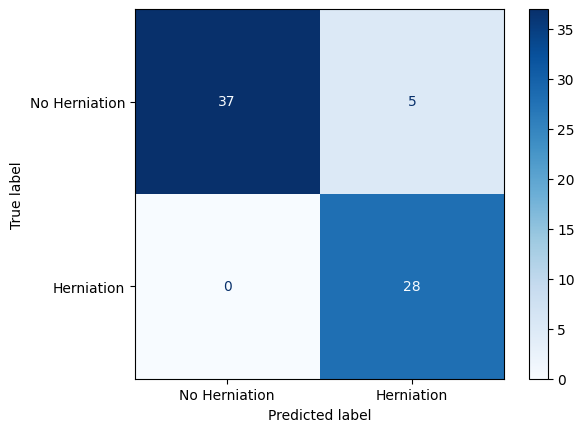

In [28]:
llama3_1step_hern_train = eval_global(
    'llama3', 
    'direct-query-hern-train',
    'april2024/direct-query/llama3_base_1step_herniation_train_new_template_yesno_scores_have_prompt'
    )

ROC AUC: 0.9795918367346939
EER threshold: 0.9915252327919006
EER: 0.07142857142857142
Balanced accuracy: 0.9107142857142858
F1 score: 0.8928571428571429
               precision    recall  f1-score   support

No Herniation       0.93      0.93      0.93        42
   Herniation       0.89      0.89      0.89        28

     accuracy                           0.91        70
    macro avg       0.91      0.91      0.91        70
 weighted avg       0.91      0.91      0.91        70



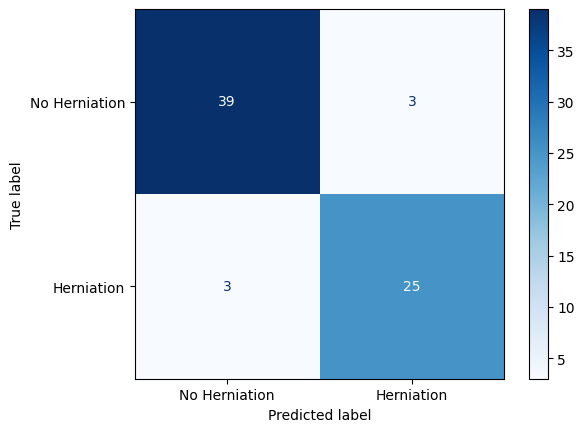

In [29]:
llama3_1step_hern_test = eval_global(
    'llama3', 
    'direct-query-hern-test',
    'april2024/direct-query/llama3_base_1step_herniation_train_new_template_yesno_scores_have_prompt',
    threshold=0.9915252327919006
    )

ROC AUC: 0.9978858350951374
EER threshold: 0.9981100559234619
EER: 0.023255813953488372
Balanced accuracy: 0.9767441860465116
F1 score: 0.9705882352941176
                   precision    recall  f1-score   support

          No Spon       1.00      0.95      0.98        43
Spondylolisthesis       0.94      1.00      0.97        33

         accuracy                           0.97        76
        macro avg       0.97      0.98      0.97        76
     weighted avg       0.98      0.97      0.97        76



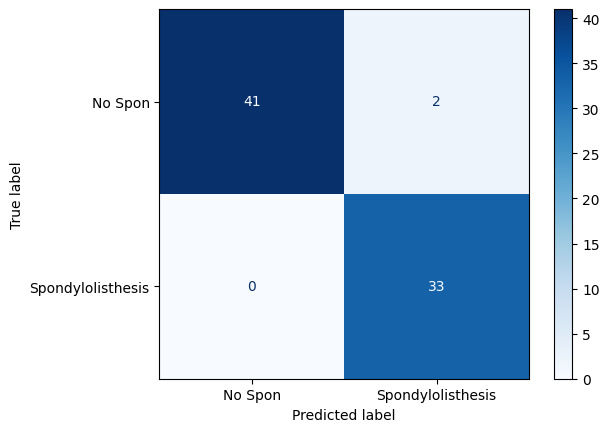

In [30]:
llama3_1step_spon_train = eval_global(
    'llama3', 
    'direct-query-spon-train',
    'april2024/direct-query/llama3_base_1step_spon_train_new_template_yesno_scores_have_prompt'
    )

ROC AUC: 0.9925775978407557
EER threshold: 0.986822247505188
EER: 0.02564102564102564
Balanced accuracy: 0.9740215924426451
F1 score: 0.9736842105263158
                   precision    recall  f1-score   support

          No Spon       0.97      0.97      0.97        39
Spondylolisthesis       0.97      0.97      0.97        38

         accuracy                           0.97        77
        macro avg       0.97      0.97      0.97        77
     weighted avg       0.97      0.97      0.97        77



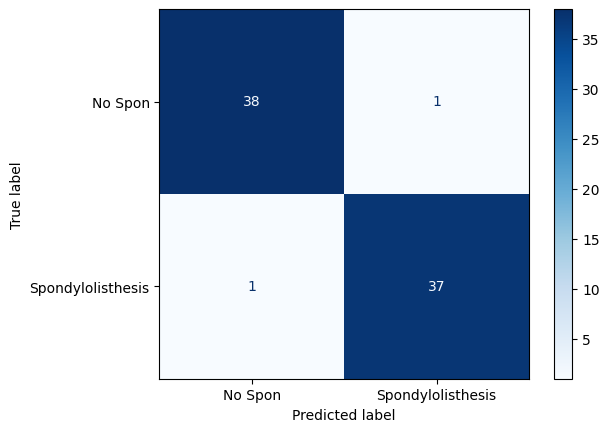

In [31]:
llama3_1step_spon_test = eval_global(
    'llama3', 
    'direct-query-spon-test',
    'april2024/direct-query/llama3_base_1step_spon_test_new_template_yesno_scores_have_prompt',
    threshold=0.9915252327919006
    )

### Two-Step Query: Base Zephyr

ROC AUC: 0.9854835411981189
EER threshold: 0.011947063729166985
EER: 0.0136986301369863
Balanced accuracy: 0.9632999386628501
F1 score: 0.9618320610687023
              precision    recall  f1-score   support

   No Cancer       0.95      0.99      0.97        73
      Cancer       0.98      0.94      0.96        67

    accuracy                           0.96       140
   macro avg       0.97      0.96      0.96       140
weighted avg       0.97      0.96      0.96       140



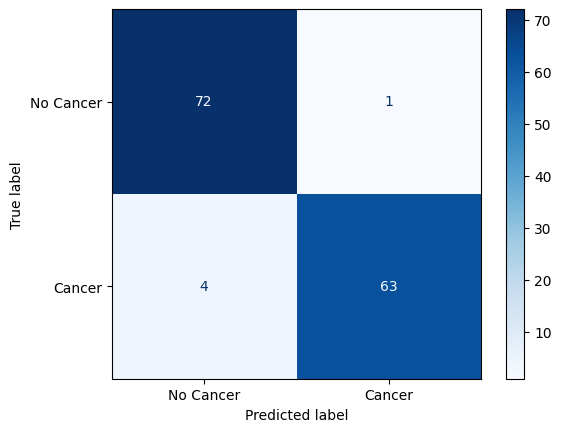

In [32]:
zephyr_2step_cancer_train = eval_global(
    'zephyr', 
    'base-base-cancer-train', 
    'april2024/summary-query/base-base/zephyr_base_2step_cancer_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 1.0
EER threshold: 5.4761545470682904e-05
EER: 0.0
Balanced accuracy: 0.9850746268656716
F1 score: 0.9848484848484849
              precision    recall  f1-score   support

   No Cancer       0.97      1.00      0.99        78
      Cancer       1.00      0.97      0.98        67

    accuracy                           0.99       145
   macro avg       0.99      0.99      0.99       145
weighted avg       0.99      0.99      0.99       145



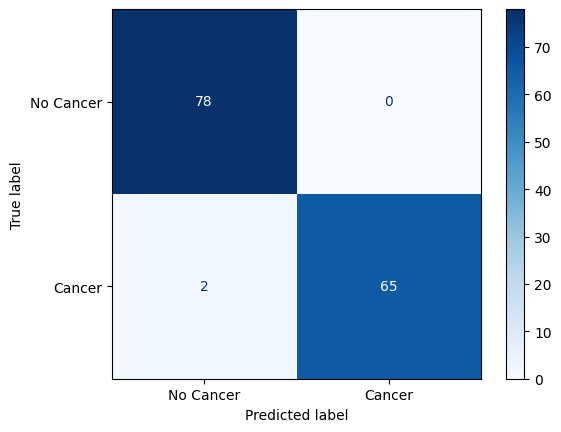

In [33]:
zephyr_2step_cancer_test = eval_global(
    'zephyr', 
    'base-base-cancer-test', 
    'april2024/summary-query/base-base/zephyr_base_2step_cancer_TRAIN_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.011947063729166985
    )

ROC AUC: 0.9111111111111111
EER threshold: 5.609211761736788e-09
EER: 0.08695652173913043
Balanced accuracy: 0.844927536231884
F1 score: 0.8354430379746834
              precision    recall  f1-score   support

 No Stenosis       0.65      0.96      0.77        23
    Stenosis       0.97      0.73      0.84        45

    accuracy                           0.81        68
   macro avg       0.81      0.84      0.80        68
weighted avg       0.86      0.81      0.81        68



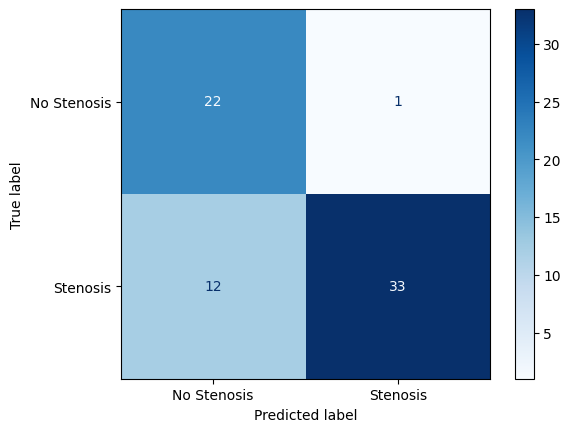

In [34]:
zephyr_2step_stenosis_train = eval_global(
    'zephyr', 
    'base-base-stenosis-train', 
    'april2024/summary-query/base-base/zephyr_base_2step_stenosis_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.9846431797651309
EER threshold: 2.810848886980466e-09
EER: 0.1111111111111111
Balanced accuracy: 0.9448961156278229
F1 score: 0.9500000000000001
              precision    recall  f1-score   support

 No Stenosis       0.90      0.96      0.93        27
    Stenosis       0.97      0.93      0.95        41

    accuracy                           0.94        68
   macro avg       0.94      0.94      0.94        68
weighted avg       0.94      0.94      0.94        68



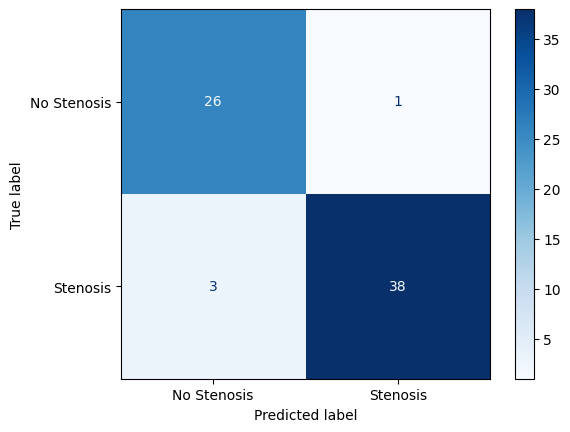

In [35]:
zephyr_2step_stenosis_test = eval_global(
    'zephyr', 
    'base-base-stenosis-test', 
    'april2024/summary-query/base-base/zephyr_base_2step_stenosis_TRAIN_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=5.609211761736788e-09
    )

ROC AUC: 0.9912280701754386
EER threshold: 0.000757920672185719
EER: 0.013157894736842105
Balanced accuracy: 0.743421052631579
F1 score: 0.6428571428571429
                 precision    recall  f1-score   support

No Cauda Equina       0.89      0.99      0.94        76
   Cauda Equina       0.90      0.50      0.64        18

       accuracy                           0.89        94
      macro avg       0.90      0.74      0.79        94
   weighted avg       0.89      0.89      0.88        94



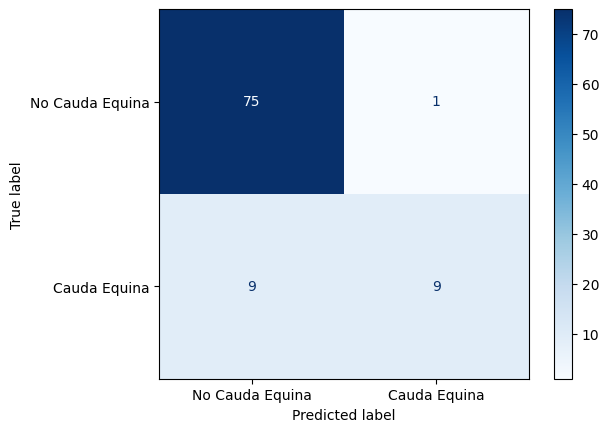

In [36]:
zephyr_2step_ce_train = eval_global(
    'zephyr', 
    'base-base-cauda-equina-train', 
    'april2024/summary-query/base-base/zephyr_base_2step_cauda_equina_train_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.9977081741787623
EER threshold: 9.592267247171549e-08
EER: 0.03896103896103896
Balanced accuracy: 0.9705882352941176
F1 score: 0.9696969696969697
                 precision    recall  f1-score   support

No Cauda Equina       0.99      1.00      0.99        77
   Cauda Equina       1.00      0.94      0.97        17

       accuracy                           0.99        94
      macro avg       0.99      0.97      0.98        94
   weighted avg       0.99      0.99      0.99        94



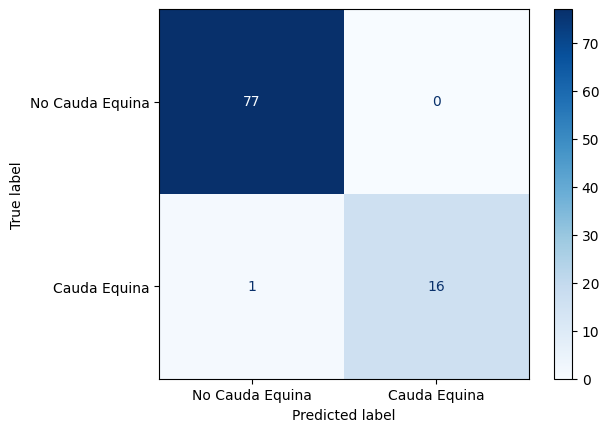

In [37]:
zephyr_2step_ce_test = eval_global(
    'zephyr', 
    'base-base-cauda-equina-test', 
    'april2024/summary-query/base-base/zephyr_base_2step_cauda_equina_test_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.000757920672185719
    )

ROC AUC: 0.7772108843537415
EER threshold: 1.0
EER: 0.3333333333333333
Balanced accuracy: 0.7261904761904763
F1 score: 0.7027027027027025
               precision    recall  f1-score   support

No Herniation       0.92      0.52      0.67        42
   Herniation       0.57      0.93      0.70        28

     accuracy                           0.69        70
    macro avg       0.74      0.73      0.68        70
 weighted avg       0.78      0.69      0.68        70



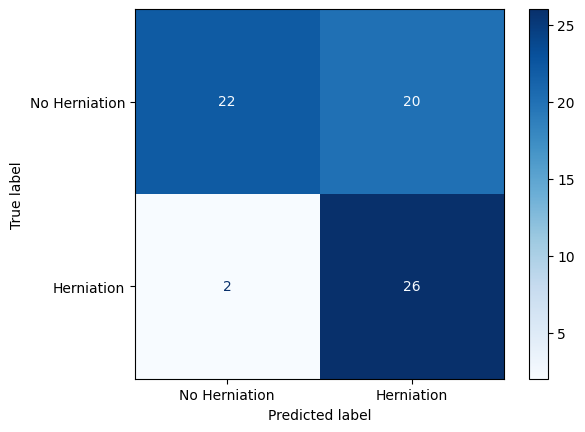

In [38]:
zephyr_2step_hern_train = eval_global(
    'zephyr', 
    'base-base-hern-train',
    'april2024/summary-query/base-base/zephyr_base_2step_herniation_train_new_template_yesno_scores_have_spec_summary_prompt'
    )

ROC AUC: 0.8154761904761905
EER threshold: 1.0
EER: 0.30952380952380953
Balanced accuracy: 0.7738095238095237
F1 score: 0.7384615384615384
               precision    recall  f1-score   support

No Herniation       0.88      0.69      0.77        42
   Herniation       0.65      0.86      0.74        28

     accuracy                           0.76        70
    macro avg       0.76      0.77      0.76        70
 weighted avg       0.79      0.76      0.76        70



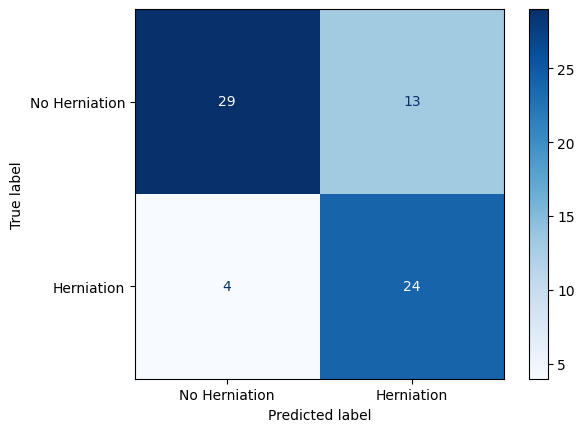

In [39]:
zephyr_2step_hern_train = eval_global(
    'zephyr', 
    'base-base-hern-test',
    'april2024/summary-query/base-base/zephyr_base_2step_herniation_test_new_template_yesno_scores_have_spec_summary_prompt',
    threshold=0.99999999999999
    )

ROC AUC: 0.985200845665962
EER threshold: 0.9999772310256958
EER: 0.023255813953488372
Balanced accuracy: 0.9464411557434813
F1 score: 0.9393939393939394
                   precision    recall  f1-score   support

          No Spon       0.95      0.95      0.95        43
Spondylolisthesis       0.94      0.94      0.94        33

         accuracy                           0.95        76
        macro avg       0.95      0.95      0.95        76
     weighted avg       0.95      0.95      0.95        76



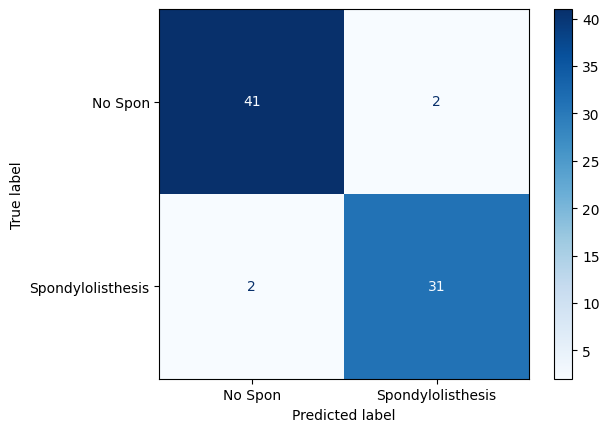

In [40]:
zephyr_2step_spon_train = eval_global(
    'zephyr', 
    'base-base-spon-train',
    'april2024/summary-query/base-base/zephyr_base_2step_spon_train_new_template_yesno_scores_have_spec_summary_prompt'
    )

ROC AUC: 0.985200845665962
EER threshold: 0.9999772310256958
EER: 0.023255813953488372
Balanced accuracy: 0.9429175475687104
F1 score: 0.9374999999999999
                   precision    recall  f1-score   support

          No Spon       0.93      0.98      0.95        43
Spondylolisthesis       0.97      0.91      0.94        33

         accuracy                           0.95        76
        macro avg       0.95      0.94      0.95        76
     weighted avg       0.95      0.95      0.95        76



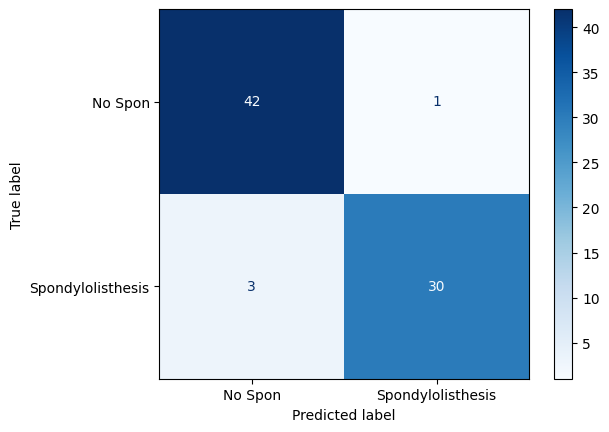

In [41]:
zephyr_2step_spon_test = eval_global(
    'zephyr', 
    'base-base-spon-test',
    'april2024/summary-query/base-base/zephyr_base_2step_spon_train_new_template_yesno_scores_have_spec_summary_prompt',
    threshold=0.9999772310256958
    )

#### Two-Step Query: Llama3

ROC AUC: 0.9981598855039868
EER threshold: 0.9301171898841858
EER: 0.0
Balanced accuracy: 0.9856879983643426
F1 score: 0.9850746268656716
              precision    recall  f1-score   support

   No Cancer       0.99      0.99      0.99        73
      Cancer       0.99      0.99      0.99        67

    accuracy                           0.99       140
   macro avg       0.99      0.99      0.99       140
weighted avg       0.99      0.99      0.99       140



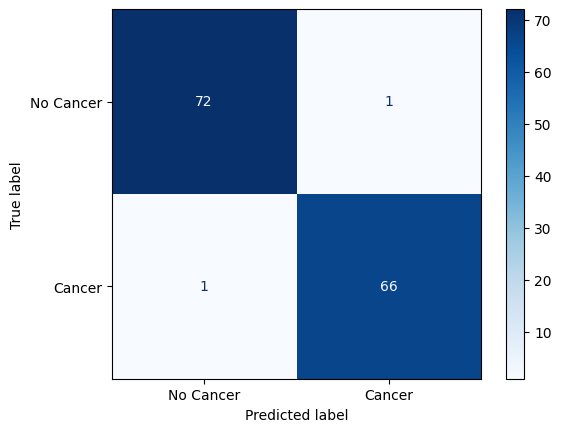

In [42]:
llama3_2step_cancer_train = eval_global(
    'llama3', 
    'base-base-cancer-train', 
    'april2024/summary-query/base-base/llama3_base_2step_cancer_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 1.0
EER threshold: 0.9747883081436157
EER: 0.0
Balanced accuracy: 1.0
F1 score: 1.0
              precision    recall  f1-score   support

   No Cancer       1.00      1.00      1.00        78
      Cancer       1.00      1.00      1.00        67

    accuracy                           1.00       145
   macro avg       1.00      1.00      1.00       145
weighted avg       1.00      1.00      1.00       145



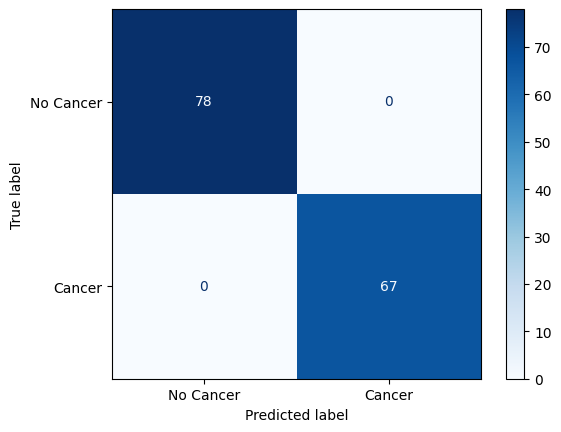

In [43]:
llama3_2step_cancer_test = eval_global(
    'llama3', 
    'base-base-cancer-test', 
    'april2024/summary-query/base-base/llama3_base_2step_cancer_TRAIN_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.9301171898841858
    )

ROC AUC: 0.9739130434782608
EER threshold: 0.9582239985466003
EER: 0.08695652173913043
Balanced accuracy: 0.8908212560386474
F1 score: 0.9347826086956522
              precision    recall  f1-score   support

 No Stenosis       0.90      0.83      0.86        23
    Stenosis       0.91      0.96      0.93        45

    accuracy                           0.91        68
   macro avg       0.91      0.89      0.90        68
weighted avg       0.91      0.91      0.91        68



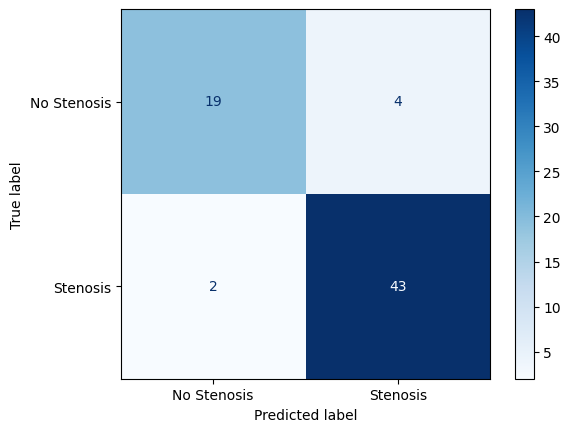

In [44]:
llama3_2step_stenosis_train = eval_global(
    'llama3', 
    'base-base-stenosis-train', 
    'april2024/summary-query/base-base/llama3_base_2step_stenosis_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.994579945799458
EER threshold: 0.8642050623893738
EER: 0.037037037037037035
Balanced accuracy: 0.9448961156278229
F1 score: 0.9500000000000001
              precision    recall  f1-score   support

 No Stenosis       0.90      0.96      0.93        27
    Stenosis       0.97      0.93      0.95        41

    accuracy                           0.94        68
   macro avg       0.94      0.94      0.94        68
weighted avg       0.94      0.94      0.94        68



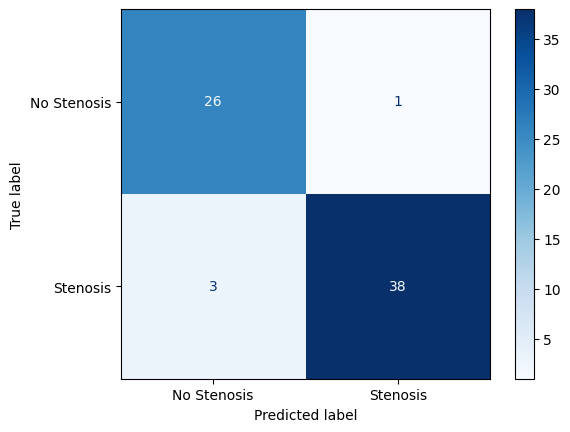

In [45]:
llama3_2step_stenosis_test = eval_global(
    'llama3', 
    'base-base-stenosis-test', 
    'april2024/summary-query/base-base/llama3_base_2step_stenosis_TRAIN_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.9582239985466003
    )

ROC AUC: 0.993421052631579
EER threshold: 0.03054085373878479
EER: 0.013157894736842105
Balanced accuracy: 0.9656432748538011
F1 score: 0.9444444444444444
                 precision    recall  f1-score   support

No Cauda Equina       0.99      0.99      0.99        76
   Cauda Equina       0.94      0.94      0.94        18

       accuracy                           0.98        94
      macro avg       0.97      0.97      0.97        94
   weighted avg       0.98      0.98      0.98        94



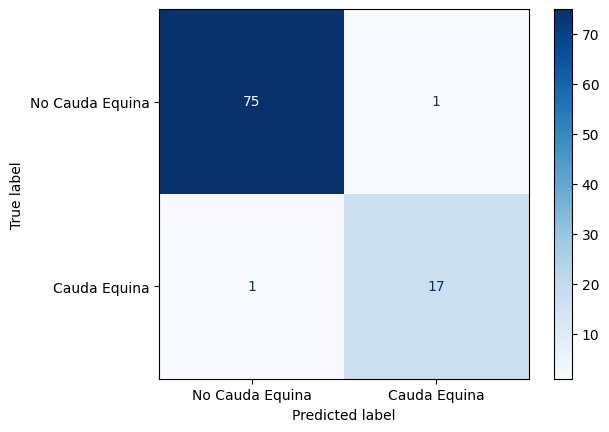

In [46]:
llama3_2step_ce_train_2step_ce_train = eval_global(
    'llama3', 
    'base-base-cauda-equina-train',
    'april2024/summary-query/base-base/llama3_base_2step_cauda_equina_train_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 1.0
EER threshold: 0.048532985150814056
EER: 0.0
Balanced accuracy: 1.0
F1 score: 1.0
                 precision    recall  f1-score   support

No Cauda Equina       1.00      1.00      1.00        77
   Cauda Equina       1.00      1.00      1.00        17

       accuracy                           1.00        94
      macro avg       1.00      1.00      1.00        94
   weighted avg       1.00      1.00      1.00        94



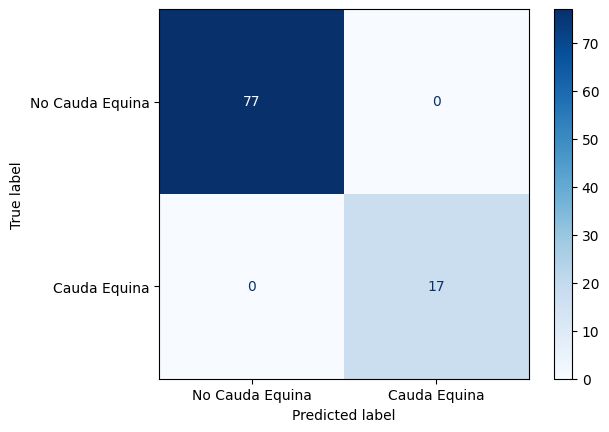

In [47]:
llama3_2step_ce_train_2step_ce_test = eval_global(
    'llama3', 
    'base-base-cauda-equina-test',
    'april2024/summary-query/base-base/llama3_base_2step_cauda_equina_test_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.03054085373878479
    )

ROC AUC: 0.9702380952380952
EER threshold: 0.07259464263916016
EER: 0.07142857142857142
Balanced accuracy: 0.9285714285714286
F1 score: 0.912280701754386
               precision    recall  f1-score   support

No Herniation       0.95      0.93      0.94        42
   Herniation       0.90      0.93      0.91        28

     accuracy                           0.93        70
    macro avg       0.92      0.93      0.93        70
 weighted avg       0.93      0.93      0.93        70



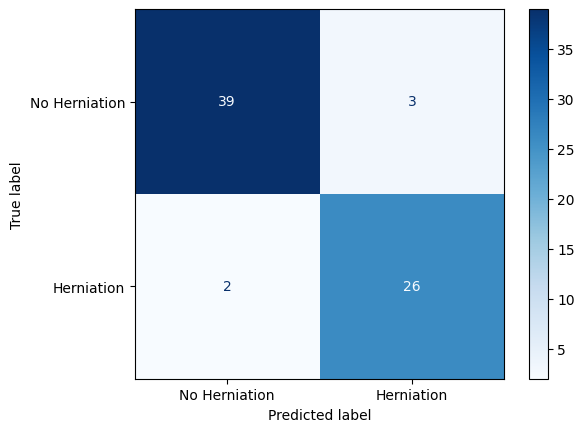

In [48]:
llama3_2step_hern_train = eval_global(
    'llama3', 
    'base-base-hern-train',
    'april2024/summary-query/base-base/llama3_base_2step_herniation_train_new_template_yesno_scores_have_spec_summary_prompt'
    )

ROC AUC: 0.989795918367347
EER threshold: 0.5777462124824524
EER: 0.07142857142857142
Balanced accuracy: 0.9464285714285714
F1 score: 0.9310344827586207
               precision    recall  f1-score   support

No Herniation       0.97      0.93      0.95        42
   Herniation       0.90      0.96      0.93        28

     accuracy                           0.94        70
    macro avg       0.94      0.95      0.94        70
 weighted avg       0.94      0.94      0.94        70



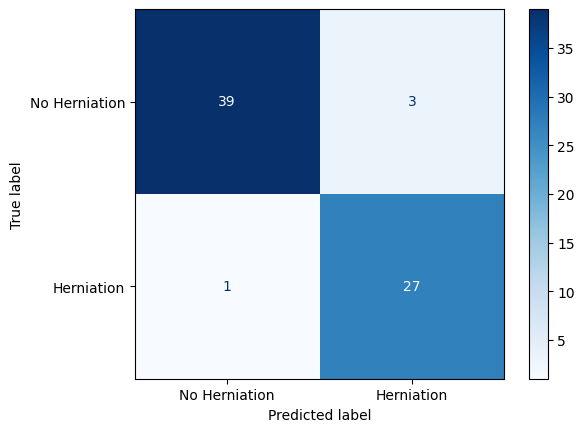

In [49]:
llama3_2step_hern_test = eval_global(
    'llama3', 
    'base-base-hern-test',
    'april2024/summary-query/base-base/llama3_base_2step_herniation_test_new_template_yesno_scores_have_spec_summary_prompt',
    threshold=0.07259464263916016
    )

ROC AUC: 0.9943622269203665
EER threshold: 0.9964028596878052
EER: 0.023255813953488372
Balanced accuracy: 0.8837209302325582
F1 score: 0.868421052631579
                   precision    recall  f1-score   support

          No Spon       1.00      0.77      0.87        43
Spondylolisthesis       0.77      1.00      0.87        33

         accuracy                           0.87        76
        macro avg       0.88      0.88      0.87        76
     weighted avg       0.90      0.87      0.87        76



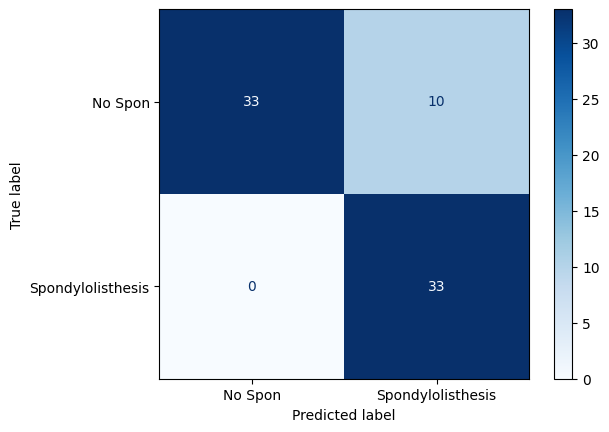

In [50]:
llama3_2step_spon_train = eval_global(
    'llama3', 
    'base-base-spon-train', 
    'april2024/summary-query/base-base/llama3_base_2step_spon_train_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.9939271255060729


EER threshold: 0.9951514005661011
EER: 0.02564102564102564
Balanced accuracy: 0.9740215924426451
F1 score: 0.9736842105263158
                   precision    recall  f1-score   support

          No Spon       0.97      0.97      0.97        39
Spondylolisthesis       0.97      0.97      0.97        38

         accuracy                           0.97        77
        macro avg       0.97      0.97      0.97        77
     weighted avg       0.97      0.97      0.97        77



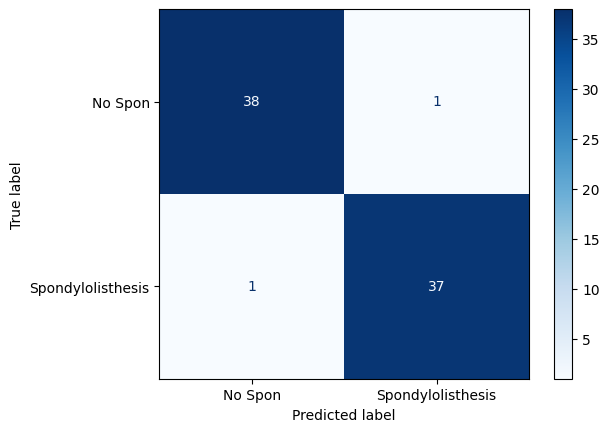

In [51]:
llama3_2step_spon_test = eval_global(
    'llama3', 
    'base-base-spon-test', 
    'april2024/summary-query/base-base/llama3_base_2step_spon_test_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.9964028596878052
    )

### Two-Step Query: Lora NTP Summary + Zephyr Query

ROC AUC: 0.9971375996728686
EER threshold: 5.927645543124527e-05
EER: 0.0273972602739726
Balanced accuracy: 0.9707626252300143
F1 score: 0.9696969696969696
              precision    recall  f1-score   support

   No Cancer       0.96      0.99      0.97        73
      Cancer       0.98      0.96      0.97        67

    accuracy                           0.97       140
   macro avg       0.97      0.97      0.97       140
weighted avg       0.97      0.97      0.97       140



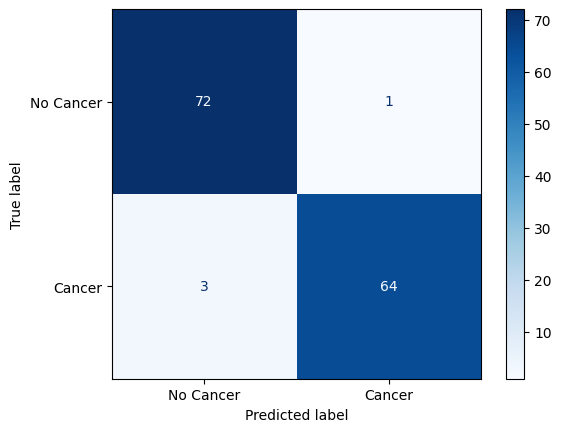

In [52]:
ntp_base_2step_cancer_train = eval_global(
    'ntp+zephyr', 
    'sft-base-cancer-train', 
    'april2024/summary-query/sft-base/zephyr_con_lora_base_2step_cancer_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 1.0
EER threshold: 0.04961172491312027
EER: 0.0
Balanced accuracy: 0.9935897435897436
F1 score: 0.9925925925925926
              precision    recall  f1-score   support

   No Cancer       1.00      0.99      0.99        78
      Cancer       0.99      1.00      0.99        67

    accuracy                           0.99       145
   macro avg       0.99      0.99      0.99       145
weighted avg       0.99      0.99      0.99       145



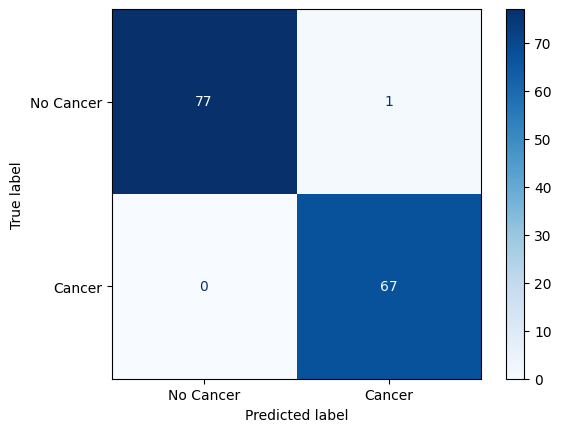

In [53]:
ntp_base_2step_cancer_test = eval_global(
    'ntp+zephyr', 
    'sft-base-cancer-test', 
    'april2024/summary-query/sft-base/zephyr_con_lora_base_2step_cancer_TRAIN_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=5.927645543124527e-05
    )

ROC AUC: 0.9536231884057972
EER threshold: 0.00011538965190993622
EER: 0.043478260869565216
Balanced accuracy: 0.7
F1 score: 0.5714285714285715
              precision    recall  f1-score   support

 No Stenosis       0.46      1.00      0.63        23
    Stenosis       1.00      0.40      0.57        45

    accuracy                           0.60        68
   macro avg       0.73      0.70      0.60        68
weighted avg       0.82      0.60      0.59        68



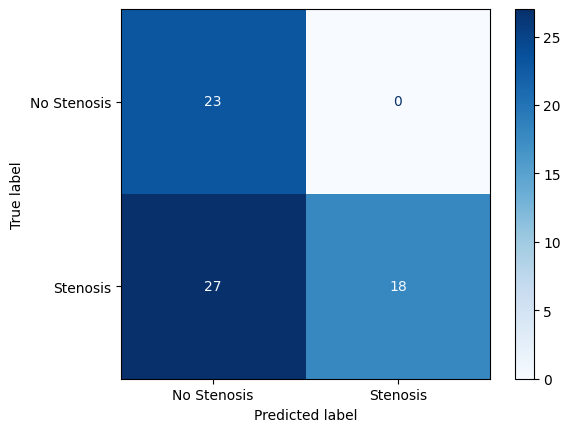

In [54]:
ntp_base_2step_stenosis_train = eval_global(
    'ntp+zephyr', 
    'sft-base-stenosis-train', 
    'april2024/summary-query/sft-base/zephyr_con_lora_base_2step_stenosis_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.9430894308943089
EER threshold: 0.00011272726987954229
EER: 0.037037037037037035
Balanced accuracy: 0.9327009936766034
F1 score: 0.9367088607594938
              precision    recall  f1-score   support

 No Stenosis       0.87      0.96      0.91        27
    Stenosis       0.97      0.90      0.94        41

    accuracy                           0.93        68
   macro avg       0.92      0.93      0.92        68
weighted avg       0.93      0.93      0.93        68



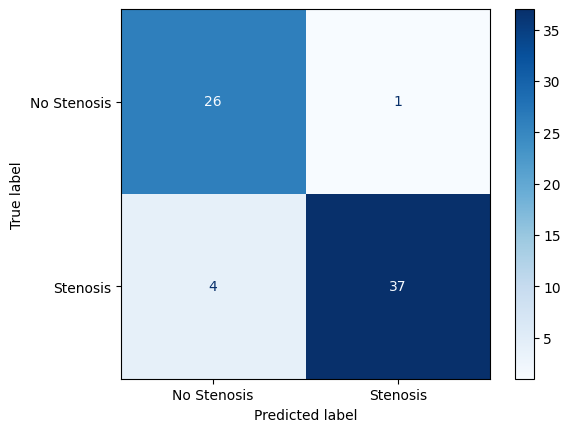

In [55]:
ntp_base_2step_stenosis_test = eval_global(
    'ntp+zephyr', 
    'sft-base-stenosis-test', 
    'april2024/summary-query/sft-base/zephyr_con_lora_base_2step_stenosis_TRAIN_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.00011538965190993622
    )

ROC AUC: 0.9919590643274854
EER threshold: 0.22469112277030945
EER: 0.013157894736842105
Balanced accuracy: 0.85453216374269
F1 score: 0.8125000000000001
                 precision    recall  f1-score   support

No Cauda Equina       0.94      0.99      0.96        76
   Cauda Equina       0.93      0.72      0.81        18

       accuracy                           0.94        94
      macro avg       0.93      0.85      0.89        94
   weighted avg       0.94      0.94      0.93        94



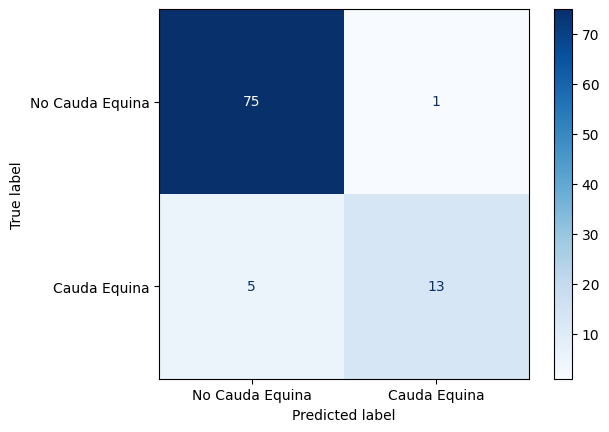

In [56]:
ntp_base_2step_ce_train = eval_global(
    'ntp+zephyr', 
    'sft-base-cauda-equina-train', 
    'april2024/summary-query/sft-base/zephyr_con_lora_base_2step_cauda_equina_train_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.9877769289533996
EER threshold: 3.269621811341494e-05
EER: 0.012987012987012988
Balanced accuracy: 0.8823529411764706
F1 score: 0.8666666666666666
                 precision    recall  f1-score   support

No Cauda Equina       0.95      1.00      0.97        77
   Cauda Equina       1.00      0.76      0.87        17

       accuracy                           0.96        94
      macro avg       0.98      0.88      0.92        94
   weighted avg       0.96      0.96      0.96        94



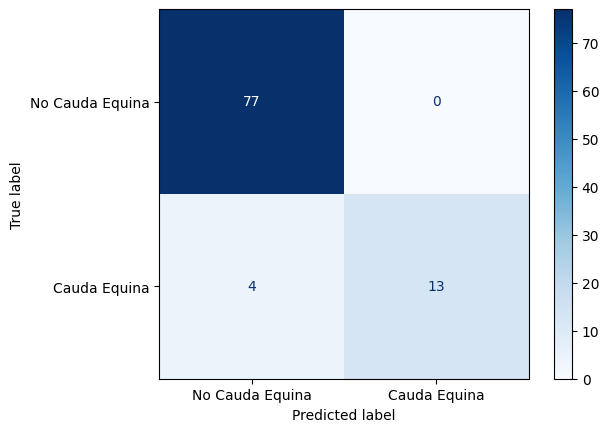

In [57]:
ntp_base_2step_ce_test = eval_global(
    'ntp+zephyr', 
    'sft-base-cauda-equina-test', 
    'april2024/summary-query/sft-base/zephyr_con_lora_base_2step_cauda_equina_test_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.22469112277030945
    )

ROC AUC: 0.7993197278911565
EER threshold: 0.002164914272725582
EER: 0.2619047619047619
Balanced accuracy: 0.7261904761904762
F1 score: 0.6530612244897959
               precision    recall  f1-score   support

No Herniation       0.76      0.88      0.81        42
   Herniation       0.76      0.57      0.65        28

     accuracy                           0.76        70
    macro avg       0.76      0.73      0.73        70
 weighted avg       0.76      0.76      0.75        70



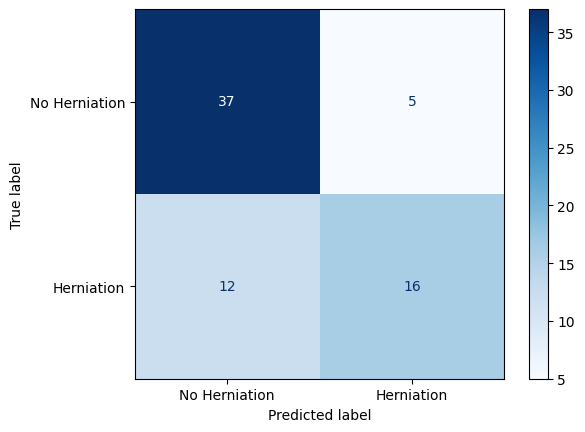

In [58]:
ntp_base_2step_hern_train = eval_global(
    'ntp+zephyr', 
    'sft-base-hern-train', 
    'april2024/summary-query/sft-base/zephyr_con_lora_base_2step_herniation_train_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.8707482993197279
EER threshold: 0.008754064328968525
EER: 0.21428571428571427
Balanced accuracy: 0.7678571428571428
F1 score: 0.73015873015873
               precision    recall  f1-score   support

No Herniation       0.86      0.71      0.78        42
   Herniation       0.66      0.82      0.73        28

     accuracy                           0.76        70
    macro avg       0.76      0.77      0.75        70
 weighted avg       0.78      0.76      0.76        70



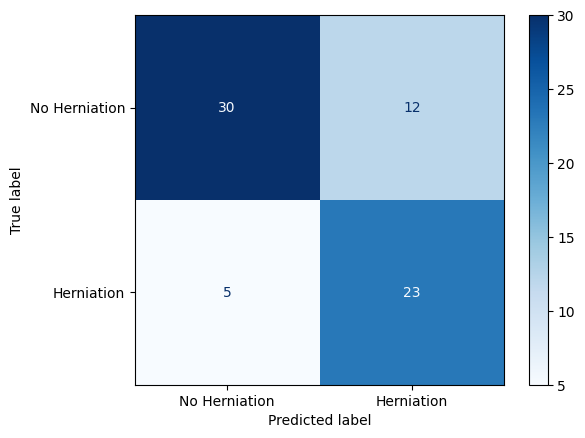

In [59]:
ntp_base_2step_hern_test = eval_global(
    'ntp+zephyr', 
    'sft-base-hern-test', 
    'april2024/summary-query/sft-base/zephyr_con_lora_base_2step_herniation_test_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.002164914272725582
    )

ROC AUC: 0.9760394644115574
EER threshold: 1.5391300621558912e-05
EER: 0.023255813953488372
Balanced accuracy: 0.8671599718111346
F1 score: 0.8474576271186441
                   precision    recall  f1-score   support

          No Spon       0.84      0.98      0.90        43
Spondylolisthesis       0.96      0.76      0.85        33

         accuracy                           0.88        76
        macro avg       0.90      0.87      0.88        76
     weighted avg       0.89      0.88      0.88        76



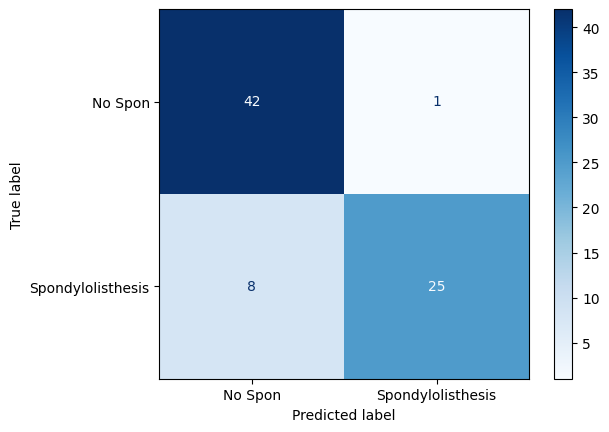

In [60]:
ntp_base_2step_spon_train = eval_global(
    'ntp+zephyr', 
    'sft-base-spon-train', 
    'april2024/summary-query/sft-base/zephyr_con_lora_base_2step_spon_train_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.9838056680161943
EER threshold: 5.2597779358620755e-06
EER: 0.02564102564102564
Balanced accuracy: 0.9477058029689609
F1 score: 0.9459459459459458
                   precision    recall  f1-score   support

          No Spon       0.93      0.97      0.95        39
Spondylolisthesis       0.97      0.92      0.95        38

         accuracy                           0.95        77
        macro avg       0.95      0.95      0.95        77
     weighted avg       0.95      0.95      0.95        77



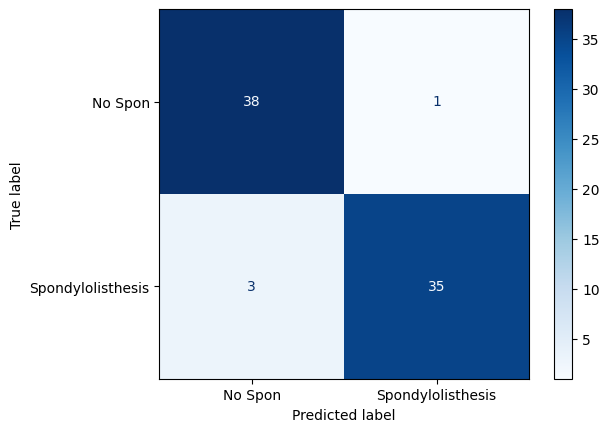

In [61]:
ntp_base_2step_spon_test = eval_global(
    'ntp+zephyr', 
    'sft-base-spon-test', 
    'april2024/summary-query/sft-base/zephyr_con_lora_base_2step_spon_test_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=1.5391300621558912e-05
    )

#### Llama3

ROC AUC: 0.998773257002658
EER threshold: 0.6921234130859375
EER: 0.0273972602739726
Balanced accuracy: 0.9726027397260274
F1 score: 0.9710144927536231
              precision    recall  f1-score   support

   No Cancer       1.00      0.95      0.97        73
      Cancer       0.94      1.00      0.97        67

    accuracy                           0.97       140
   macro avg       0.97      0.97      0.97       140
weighted avg       0.97      0.97      0.97       140



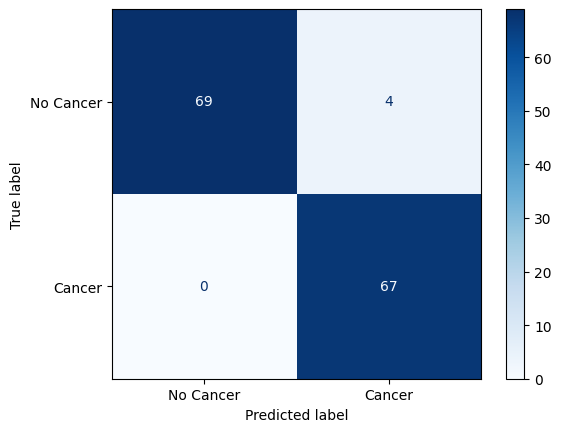

In [62]:
llama3_ntp_base_2step_cancer_train = eval_global(
    'ntp+llama3', 
    'sft-base-cancer-train', 
    'april2024/summary-query/sft-base/llama3_con_lora_base_2step_cancer_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.9910065059318791
EER threshold: 0.9101793766021729
EER: 0.01282051282051282
Balanced accuracy: 0.9722541140451588
F1 score: 0.9701492537313433
              precision    recall  f1-score   support

   No Cancer       0.97      0.97      0.97        78
      Cancer       0.97      0.97      0.97        67

    accuracy                           0.97       145
   macro avg       0.97      0.97      0.97       145
weighted avg       0.97      0.97      0.97       145



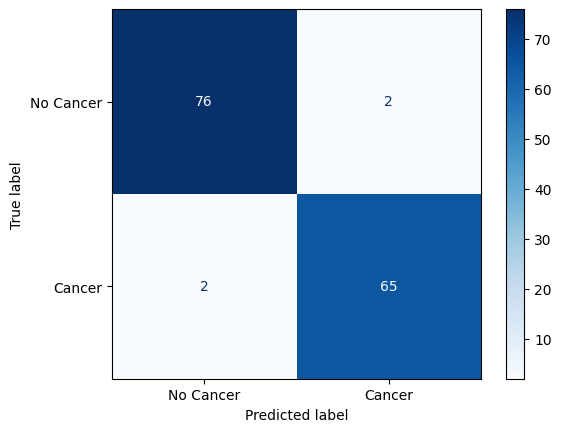

In [63]:
llama3_ntp_base_2step_cancer_test = eval_global(
    'ntp+llama3', 
    'sft-base-cancer-test', 
    'april2024/summary-query/sft-base/llama3_con_lora_base_2step_cancer_TRAIN_new_template_yesno_scores_have_spec_summary_prompt',
    threshold=0.6921234130859375
    )

ROC AUC: 0.8502415458937198
EER threshold: 0.9492835402488708
EER: 0.21739130434782608
Balanced accuracy: 0.7705314009661836
F1 score: 0.8602150537634408
              precision    recall  f1-score   support

 No Stenosis       0.75      0.65      0.70        23
    Stenosis       0.83      0.89      0.86        45

    accuracy                           0.81        68
   macro avg       0.79      0.77      0.78        68
weighted avg       0.81      0.81      0.81        68



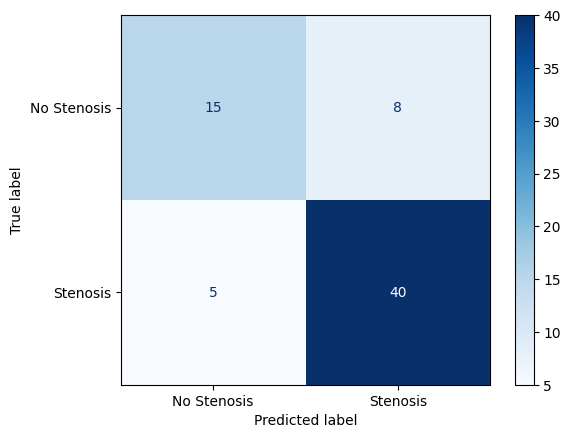

In [64]:
llama3_ntp_base_2step_stenosis_train = eval_global(
    'ntp+llama3', 
    'sft-base-stenosis-train', 
    'april2024/summary-query/sft-base/llama3_con_lora_base_2step_stenosis_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.8979223125564588
EER threshold: 0.9686349034309387
EER: 0.18518518518518517
Balanced accuracy: 0.8401084010840109
F1 score: 0.8809523809523809
              precision    recall  f1-score   support

 No Stenosis       0.84      0.78      0.81        27
    Stenosis       0.86      0.90      0.88        41

    accuracy                           0.85        68
   macro avg       0.85      0.84      0.84        68
weighted avg       0.85      0.85      0.85        68



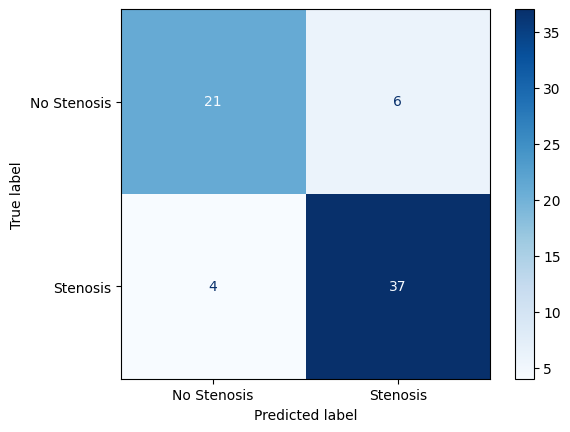

In [65]:
llama3_ntp_base_2step_stenosis_test = eval_global(
    'ntp+llama3', 
    'sft-base-stenosis-test', 
    'april2024/summary-query/sft-base/llama3_con_lora_base_2step_stenosis_TRAIN_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.9492835402488708
    )

ROC AUC: 0.9809941520467836
EER threshold: 0.88526451587677
EER: 0.039473684210526314
Balanced accuracy: 0.9802631578947368
F1 score: 0.923076923076923
                 precision    recall  f1-score   support

No Cauda Equina       1.00      0.96      0.98        76
   Cauda Equina       0.86      1.00      0.92        18

       accuracy                           0.97        94
      macro avg       0.93      0.98      0.95        94
   weighted avg       0.97      0.97      0.97        94



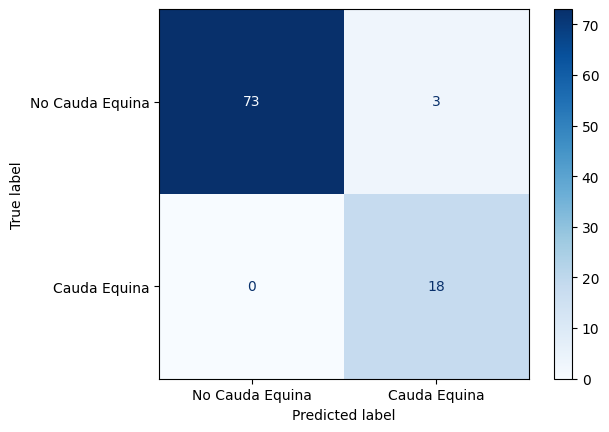

In [66]:
llama3_ntp_base_2step_ce_train = eval_global(
    'ntp+llama3', 
    'sft-base-cauda-equina-train', 
    'april2024/summary-query/sft-base/llama3_con_lora_base_2step_cauda_equina_train_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.9862490450725745
EER threshold: 0.5624486804008484
EER: 0.03896103896103896
Balanced accuracy: 0.8922841864018334
F1 score: 0.8235294117647058
                 precision    recall  f1-score   support

No Cauda Equina       0.96      0.96      0.96        77
   Cauda Equina       0.82      0.82      0.82        17

       accuracy                           0.94        94
      macro avg       0.89      0.89      0.89        94
   weighted avg       0.94      0.94      0.94        94



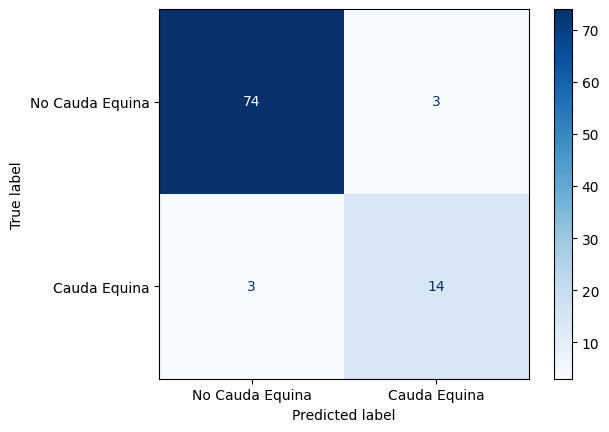

In [67]:
llama3_ntp_base_2step_ce_test = eval_global(
    'ntp+llama3', 
    'sft-base-cauda-equina-test', 
    'april2024/summary-query/sft-base/llama3_con_lora_base_2step_cauda_equina_test_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.88526451587677
    )

ROC AUC: 0.6904761904761906
EER threshold: 0.20162710547447205
EER: 0.35714285714285715
Balanced accuracy: 0.6309523809523809
F1 score: 0.5106382978723404
               precision    recall  f1-score   support

No Herniation       0.69      0.83      0.75        42
   Herniation       0.63      0.43      0.51        28

     accuracy                           0.67        70
    macro avg       0.66      0.63      0.63        70
 weighted avg       0.66      0.67      0.66        70



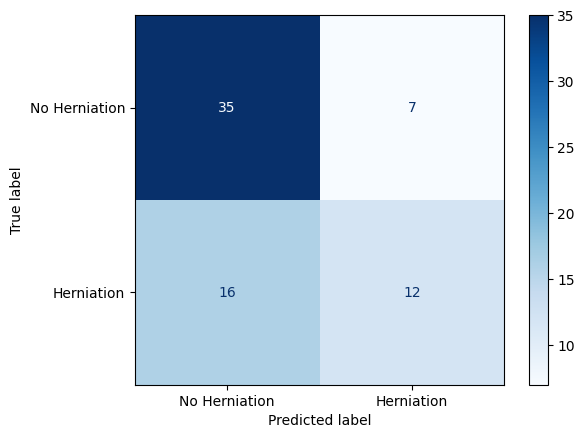

In [68]:
llama3_ntp_base_2step_hern_train = eval_global(
    'ntp+llama3', 
    'sft-base-hern-train', 
    'april2024/summary-query/sft-base/llama3_con_lora_base_2step_herniation_train_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=None
    )

ROC AUC: 0.7933673469387755
EER threshold: 0.14691248536109924
EER: 0.2619047619047619
Balanced accuracy: 0.7202380952380952
F1 score: 0.6538461538461539
               precision    recall  f1-score   support

No Herniation       0.76      0.83      0.80        42
   Herniation       0.71      0.61      0.65        28

     accuracy                           0.74        70
    macro avg       0.73      0.72      0.72        70
 weighted avg       0.74      0.74      0.74        70



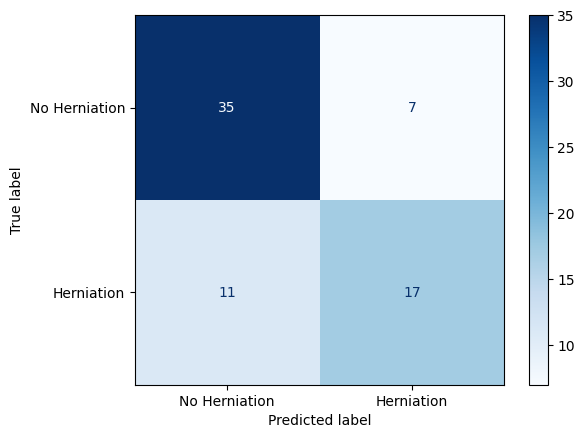

In [69]:
llama3_ntp_base_2step_hern_test = eval_global(
    'ntp+llama3', 
    'sft-base-hern-test', 
    'april2024/summary-query/sft-base/llama3_con_lora_base_2step_herniation_test_new_template_yesno_scores_have_spec_summary_prompt', 
    threshold=0.20162710547447205
    )

In [70]:
df_results = pd.DataFrame(li_results)

In [71]:
df_results_cancer = df_results.loc[df_results.desc.str.find('cancer') > -1]
df_results_cancer

,model,desc,balanced_accuracy,eer,auroc,f1_score
0,gpt4,direct-query-cancer-test,1.000000,-,-,1.000000
5,zephyr,direct-query-cancer-test,0.992537,0.0,1.0,0.992481
10,llama3,direct-query-cancer-test,0.978225,0.013699,0.998773,0.977444
15,zephyr,base-base-cancer-test,0.985075,0.0,1.0,0.984848
20,llama3,base-base-cancer-test,1.000000,0.0,1.0,1.000000
25,ntp+zephyr,sft-base-cancer-test,0.993590,0.0,1.0,0.992593
30,ntp+llama3,sft-base-cancer-test,0.972254,0.012821,0.991007,0.970149


In [72]:
df_results_stenosis = df_results.loc[df_results.desc.str.find('stenosis') > -1]
df_results_stenosis

,model,desc,balanced_accuracy,eer,auroc,f1_score
1,gpt4,direct-query-stenosis-test,0.951220,-,-,0.948718
6,zephyr,direct-query-stenosis-test,0.944896,0.037037,0.98103,0.950000
11,llama3,direct-query-stenosis-test,0.963415,0.0,0.987353,0.962025
16,zephyr,base-base-stenosis-test,0.944896,0.111111,0.984643,0.950000
21,llama3,base-base-stenosis-test,0.944896,0.037037,0.99458,0.950000
26,ntp+zephyr,sft-base-stenosis-test,0.932701,0.037037,0.943089,0.936709
31,ntp+llama3,sft-base-stenosis-test,0.840108,0.185185,0.897922,0.880952


In [73]:
df_results_cauda = df_results.loc[df_results.desc.str.find('cauda') > -1]
df_results_cauda

,model,desc,balanced_accuracy,eer,auroc,f1_score
2,gpt4,direct-query-cauda-equina-test,1.000000,-,-,1.000000
7,zephyr,direct-query-cauda-equina-test,0.911765,0.012987,0.971734,0.903226
12,llama3,direct-query-cauda-equina-test,0.941176,0.025974,0.997708,0.937500
17,zephyr,base-base-cauda-equina-test,0.970588,0.038961,0.997708,0.969697
22,llama3,base-base-cauda-equina-test,1.000000,0.0,1.0,1.000000
27,ntp+zephyr,sft-base-cauda-equina-test,0.882353,0.012987,0.987777,0.866667
32,ntp+llama3,sft-base-cauda-equina-test,0.892284,0.038961,0.986249,0.823529


In [74]:
df_results_hern = df_results.loc[df_results.desc.str.find('hern') > -1]
df_results_hern

,model,desc,balanced_accuracy,eer,auroc,f1_score
3,gpt4,direct-query-herniation-test,0.934524,-,-,0.915254
8,zephyr,direct-query-hern-test,0.869048,0.119048,0.946854,0.842105
13,llama3,direct-query-hern-test,0.910714,0.071429,0.979592,0.892857
18,zephyr,base-base-hern-test,0.773810,0.309524,0.815476,0.738462
23,llama3,base-base-hern-test,0.946429,0.071429,0.989796,0.931034
28,ntp+zephyr,sft-base-hern-test,0.767857,0.214286,0.870748,0.730159
33,ntp+llama3,sft-base-hern-test,0.720238,0.261905,0.793367,0.653846


In [75]:
df_results_spon = df_results.loc[df_results.desc.str.find('spon') > -1]
df_results_spon

,model,desc,balanced_accuracy,eer,auroc,f1_score
4,gpt4,direct-query-spon-test,0.973684,-,-,0.972973
9,zephyr,direct-query-spon-test,0.974022,0.025641,0.995951,0.973684
14,llama3,direct-query-spon-test,0.974022,0.025641,0.992578,0.973684
19,zephyr,base-base-spon-test,0.942918,0.023256,0.985201,0.937500
24,llama3,base-base-spon-test,0.974022,0.025641,0.993927,0.973684
29,ntp+zephyr,sft-base-spon-test,0.947706,0.025641,0.983806,0.945946


## IVD-Level Results for Stenosis

ROC AUC: 0.9342560553633219
Balanced accuracy: 0.9019607843137254
F1 score: 0.8333333333333333
EER threshold: 0.5957925319671631
EER: 0.0784313725490196
              precision    recall  f1-score   support

 No Stenosis       0.96      0.92      0.94        51
    Stenosis       0.79      0.88      0.83        17

    accuracy                           0.91        68
   macro avg       0.87      0.90      0.89        68
weighted avg       0.92      0.91      0.91        68



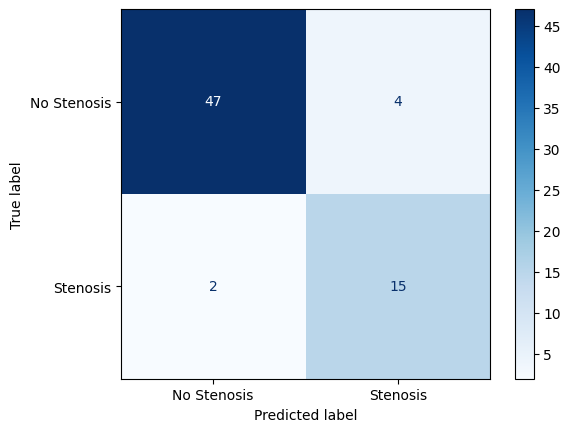

In [76]:
llama_base_2step_stenosis_l3l4_train = eval_level('stenosis', 'L3-L4', threshold=None)

ROC AUC: 0.9678321678321679
Balanced accuracy: 0.8958041958041958
F1 score: 0.8148148148148148
EER threshold: 0.45438912510871887
EER: 0.07272727272727272
              precision    recall  f1-score   support

 No Stenosis       0.96      0.95      0.95        55
    Stenosis       0.79      0.85      0.81        13

    accuracy                           0.93        68
   macro avg       0.87      0.90      0.88        68
weighted avg       0.93      0.93      0.93        68



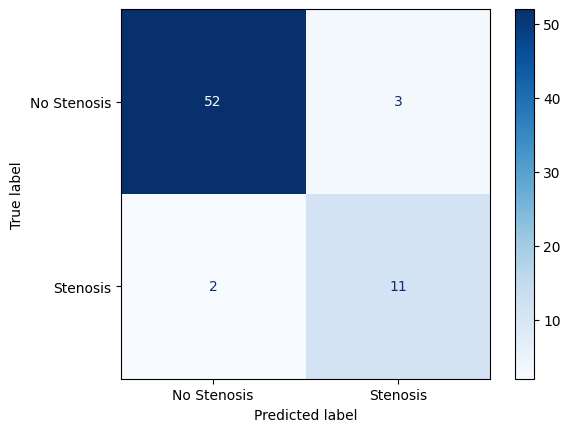

In [77]:
llama_base_2step_stenosis_l3l4_test = eval_level('stenosis_TRAIN', 'L3-L4', threshold=0.5957925319671631)

ROC AUC: 0.9017543859649122
Balanced accuracy: 0.8017543859649123
F1 score: 0.7878787878787877


EER threshold: 0.9059188365936279
EER: 0.18421052631578946
              precision    recall  f1-score   support

 No Stenosis       0.88      0.74      0.80        38
    Stenosis       0.72      0.87      0.79        30

    accuracy                           0.79        68
   macro avg       0.80      0.80      0.79        68
weighted avg       0.81      0.79      0.79        68



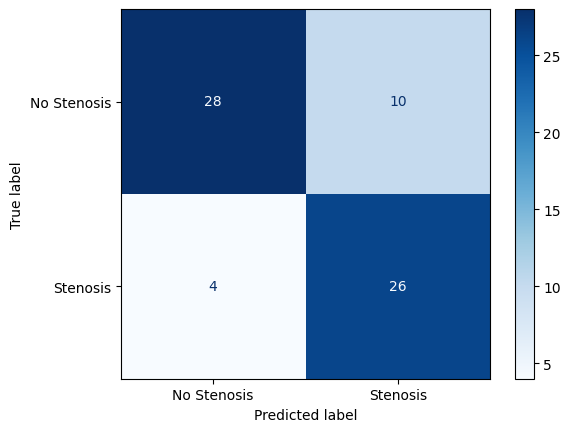

In [78]:
llama_base_2step_stenosis_l4l5_train = eval_level('stenosis', 'L4-L5', threshold=None)

ROC AUC: 0.9782040104620751
Balanced accuracy: 0.9084568439407149
F1 score: 0.9
EER threshold: 0.6253496408462524
EER: 0.10810810810810811
              precision    recall  f1-score   support

 No Stenosis       0.90      0.95      0.92        37
    Stenosis       0.93      0.87      0.90        31

    accuracy                           0.91        68
   macro avg       0.91      0.91      0.91        68
weighted avg       0.91      0.91      0.91        68



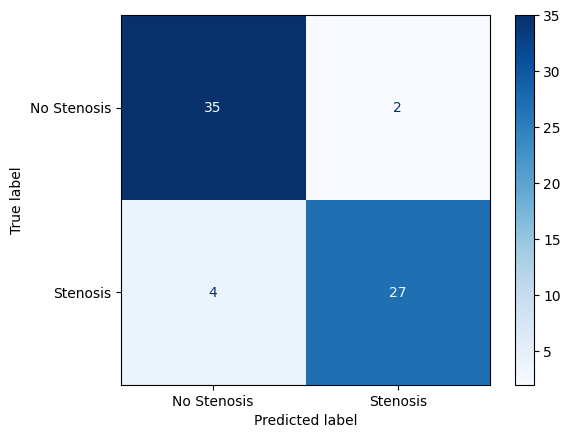

In [79]:
llama_base_2step_stenosis_l4l5_test = eval_level('stenosis_TRAIN', 'L4-L5', threshold=0.9059188365936279)

ROC AUC: 0.9596491228070176
Balanced accuracy: 0.8614035087719298
F1 score: 0.8484848484848485
EER threshold: 0.8589565753936768
EER: 0.07894736842105263
              precision    recall  f1-score   support

 No Stenosis       0.94      0.79      0.86        38
    Stenosis       0.78      0.93      0.85        30

    accuracy                           0.85        68
   macro avg       0.86      0.86      0.85        68
weighted avg       0.87      0.85      0.85        68



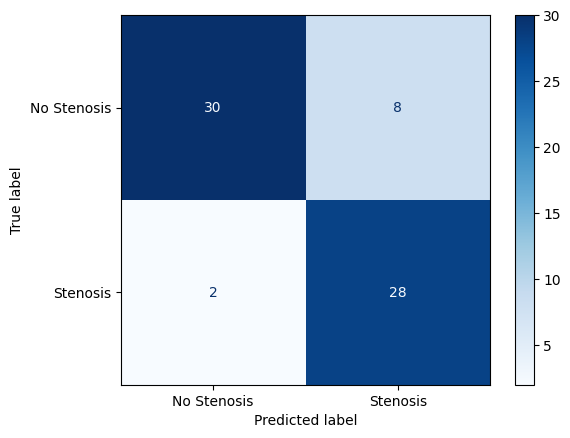

In [80]:
llama_base_2step_stenosis_l5s1_train = eval_level('stenosis', 'L5-S1', threshold=None)

ROC AUC: 0.9446428571428571
Balanced accuracy: 0.8553571428571429
F1 score: 0.830188679245283
EER threshold: 0.33229073882102966
EER: 0.15
              precision    recall  f1-score   support

 No Stenosis       0.86      0.93      0.89        40
    Stenosis       0.88      0.79      0.83        28

    accuracy                           0.87        68
   macro avg       0.87      0.86      0.86        68
weighted avg       0.87      0.87      0.87        68



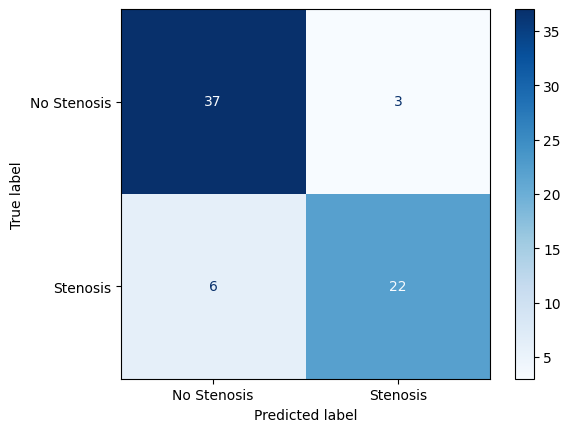

In [81]:
llama_base_2step_stenosis_l5s1_test = eval_level('stenosis_TRAIN', 'L5-S1', threshold=0.8589565753936768)

In [82]:
df_level_results = pd.DataFrame(li_level_results)
df_level_results

,condition,level,balanced_accuracy,eer,auroc,f1_score
0,stenosis,L3-L4,0.895804,0.072727,0.967832,0.814815
1,stenosis,L4-L5,0.908457,0.108108,0.978204,0.900000
2,stenosis,L5-S1,0.855357,0.150000,0.944643,0.830189


### Herniation by Level

ROC AUC: 1.0
Balanced accuracy: 0.9848484848484849
F1 score: 0.7499999999999999
EER threshold: 0.9894529581069946
EER: 0.0
               precision    recall  f1-score   support

No Herniation       1.00      0.97      0.98        66
   Herniation       0.60      1.00      0.75         3

     accuracy                           0.97        69
    macro avg       0.80      0.98      0.87        69
 weighted avg       0.98      0.97      0.97        69



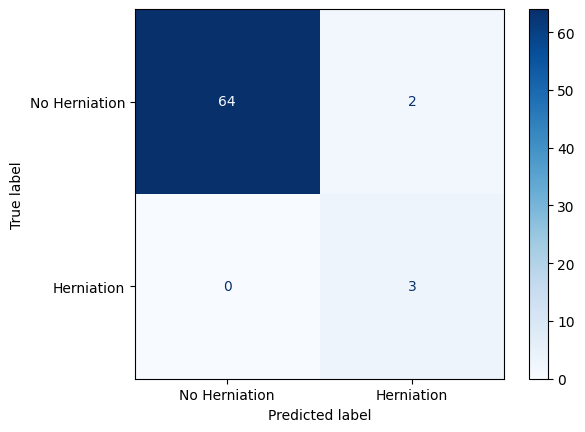

In [83]:
llama_base_2step_hern_l3l4_train = eval_level('herniation_train', 'L3-L4', threshold=None)

ROC AUC: 0.9476923076923076
Balanced accuracy: 0.8
F1 score: 0.7499999999999999
EER threshold: 0.059760067611932755
EER: 0.23076923076923078
               precision    recall  f1-score   support

No Herniation       0.97      1.00      0.98        65
   Herniation       1.00      0.60      0.75         5

     accuracy                           0.97        70
    macro avg       0.99      0.80      0.87        70
 weighted avg       0.97      0.97      0.97        70



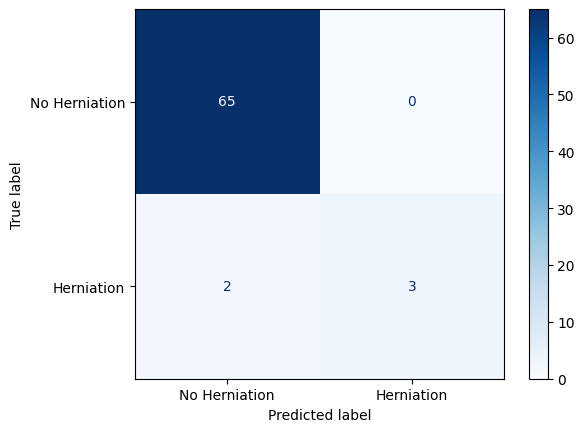

In [84]:
llama_base_2step_hern_l3l4_test = eval_level('herniation_test', 'L3-L4', threshold=0.9894529581069946)

ROC AUC: 0.946551724137931
Balanced accuracy: 0.8724137931034484
F1 score: 0.6428571428571429
EER threshold: 0.9944387674331665
EER: 0.05172413793103448
               precision    recall  f1-score   support

No Herniation       0.98      0.84      0.91        58
   Herniation       0.50      0.90      0.64        10

     accuracy                           0.85        68
    macro avg       0.74      0.87      0.78        68
 weighted avg       0.91      0.85      0.87        68



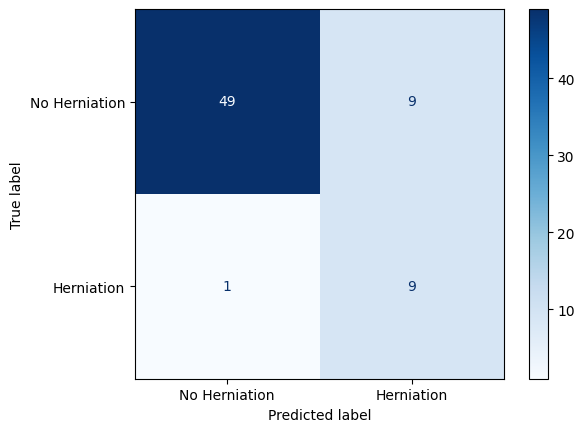

In [85]:
llama_base_2step_hern_l4l5_train = eval_level('herniation_train', 'L4-L5', threshold=None)

ROC AUC: 0.9693877551020409
Balanced accuracy: 0.9196428571428571
F1 score: 0.888888888888889
EER threshold: 0.9935483336448669
EER: 0.017857142857142856
               precision    recall  f1-score   support

No Herniation       0.96      0.98      0.97        56
   Herniation       0.92      0.86      0.89        14

     accuracy                           0.96        70
    macro avg       0.94      0.92      0.93        70
 weighted avg       0.96      0.96      0.96        70



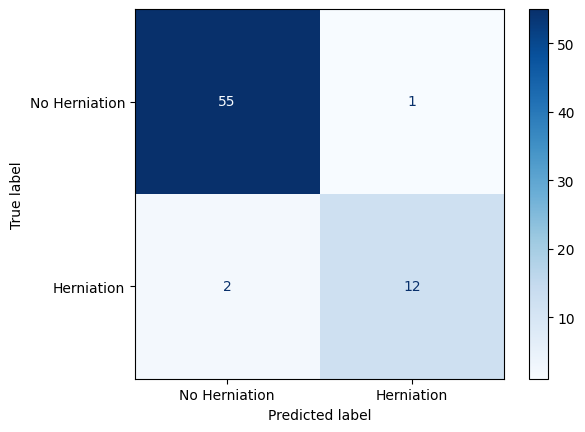

In [86]:
llama_base_2step_hern_l4l5_test = eval_level('herniation_test', 'L4-L5', threshold=0.9944387674331665)

ROC AUC: 0.974025974025974
Balanced accuracy: 0.9545454545454546
F1 score: 0.8484848484848484
EER threshold: 0.8388778567314148
EER: 0.05454545454545454
               precision    recall  f1-score   support

No Herniation       1.00      0.91      0.95        55
   Herniation       0.74      1.00      0.85        14

     accuracy                           0.93        69
    macro avg       0.87      0.95      0.90        69
 weighted avg       0.95      0.93      0.93        69



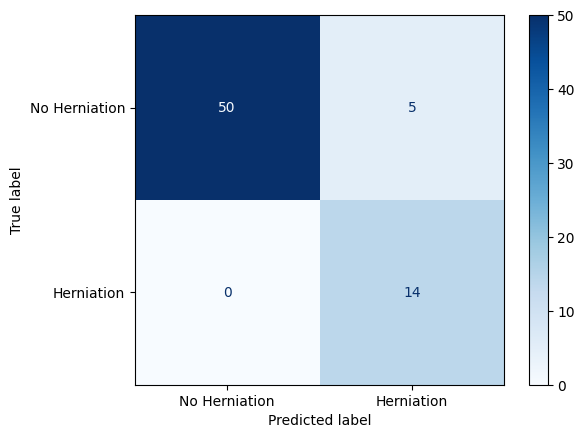

In [87]:
llama_base_2step_hern_l5s1_train = eval_level('herniation_train', 'L5-S1', threshold=None)

ROC AUC: 0.9260400616332819
Balanced accuracy: 0.8212634822804314
F1 score: 0.6666666666666667
EER threshold: 0.42784443497657776
EER: 0.11864406779661017
               precision    recall  f1-score   support

No Herniation       0.95      0.92      0.93        59
   Herniation       0.62      0.73      0.67        11

     accuracy                           0.89        70
    macro avg       0.78      0.82      0.80        70
 weighted avg       0.90      0.89      0.89        70



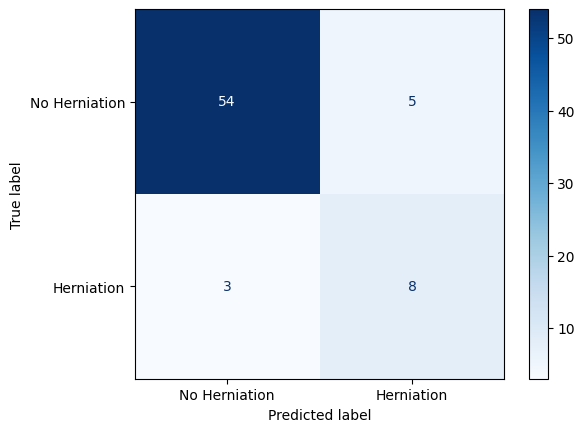

In [88]:
llama_base_2step_hern_l5s1_test = eval_level('herniation_test', 'L5-S1', threshold=0.8388778567314148)

ROC AUC: 1.0
Balanced accuracy: 0.9452054794520548
F1 score: 0.42857142857142855
EER threshold: 0.9982767105102539
EER: 0.0
                   precision    recall  f1-score   support

          No Spon       1.00      0.89      0.94        73
Spondylolisthesis       0.27      1.00      0.43         3

         accuracy                           0.89        76
        macro avg       0.64      0.95      0.69        76
     weighted avg       0.97      0.89      0.92        76



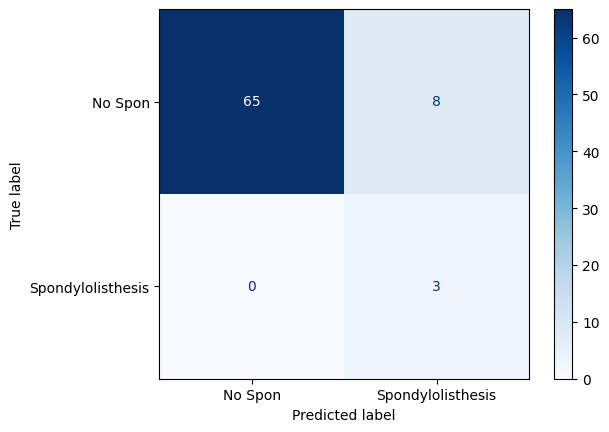

In [89]:
llama_base_2step_spon_l3l4_train = eval_level('spon_train', 'L3-L4', threshold=None)

ROC AUC: 0.9982142857142857
Balanced accuracy: 0.875
F1 score: 0.8571428571428571
EER threshold: 0.9942619800567627
EER: 0.014285714285714285
                   precision    recall  f1-score   support

          No Spon       0.97      1.00      0.99        70
Spondylolisthesis       1.00      0.75      0.86         8

         accuracy                           0.97        78
        macro avg       0.99      0.88      0.92        78
     weighted avg       0.98      0.97      0.97        78



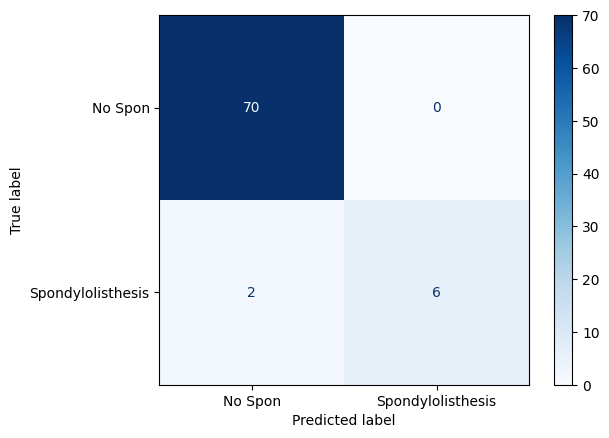

In [90]:
llama_base_2step_spon_l3l4_test = eval_level('spon_test', 'L3-L4', threshold=0.9982767105102539)

ROC AUC: 1.0
Balanced accuracy: 0.9636363636363636
F1 score: 0.9130434782608696
EER threshold: 0.9975467324256897
EER: 0.0
                   precision    recall  f1-score   support

          No Spon       1.00      0.93      0.96        55
Spondylolisthesis       0.84      1.00      0.91        21

         accuracy                           0.95        76
        macro avg       0.92      0.96      0.94        76
     weighted avg       0.96      0.95      0.95        76



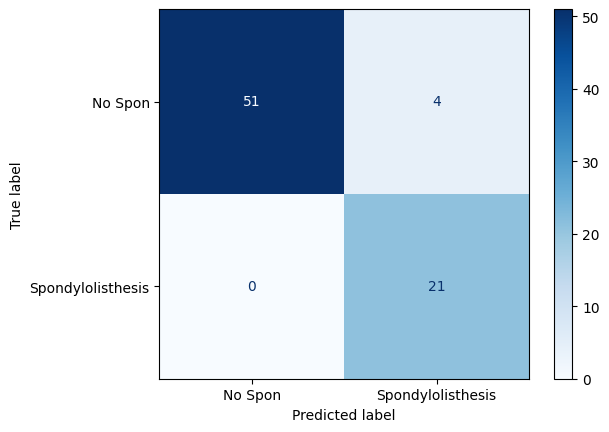

In [91]:
llama_base_2step_spon_l4l5_train = eval_level('spon_train', 'L4-L5', threshold=None)

ROC AUC: 1.0
Balanced accuracy: 1.0
F1 score: 1.0
EER threshold: 0.9987332224845886
EER: 0.0
                   precision    recall  f1-score   support

          No Spon       1.00      1.00      1.00        61
Spondylolisthesis       1.00      1.00      1.00        16

         accuracy                           1.00        77
        macro avg       1.00      1.00      1.00        77
     weighted avg       1.00      1.00      1.00        77



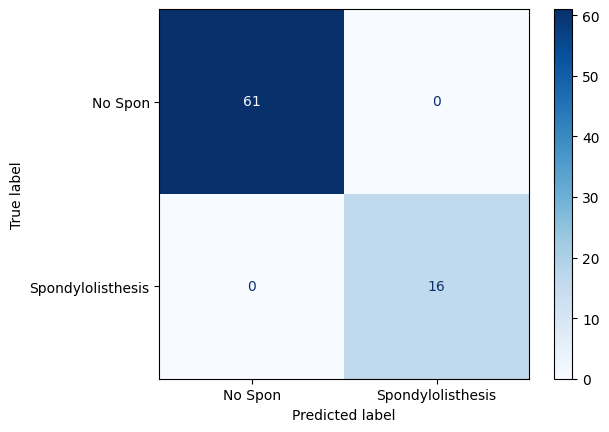

In [92]:
llama_base_2step_spon_l4l5_test = eval_level('spon_test', 'L4-L5', threshold=0.9975467324256897)

ROC AUC: 0.9856770833333334
Balanced accuracy: 0.9140625
F1 score: 0.6857142857142856
EER threshold: 0.9998051524162292
EER: 0.015625
                   precision    recall  f1-score   support

          No Spon       1.00      0.83      0.91        64
Spondylolisthesis       0.52      1.00      0.69        12

         accuracy                           0.86        76
        macro avg       0.76      0.91      0.80        76
     weighted avg       0.92      0.86      0.87        76



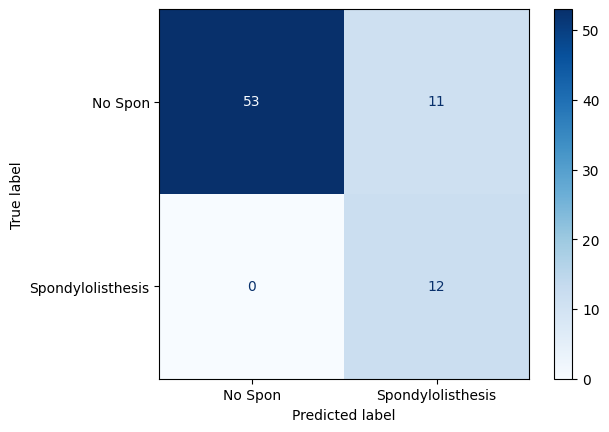

In [93]:
llama_base_2step_spon_l5s1_train = eval_level('spon_train', 'L5-S1', threshold=None)

ROC AUC: 0.9937555753791258
Balanced accuracy: 0.8336306868867083
F1 score: 0.7878787878787878
EER threshold: 0.9976502060890198
EER: 0.01694915254237288
                   precision    recall  f1-score   support

          No Spon       0.91      0.98      0.94        59
Spondylolisthesis       0.93      0.68      0.79        19

         accuracy                           0.91        78
        macro avg       0.92      0.83      0.87        78
     weighted avg       0.91      0.91      0.91        78



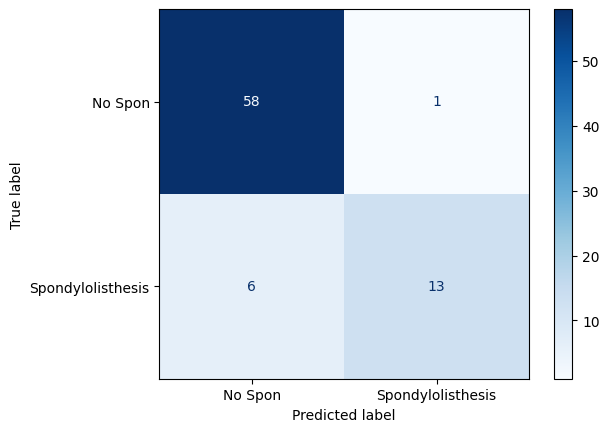

In [94]:
llama_base_2step_spon_l5s1_test = eval_level('spon_test', 'L5-S1', threshold=0.9998051524162292)

In [95]:
df_level_results = pd.DataFrame(li_level_results)
df_level_results

,condition,level,balanced_accuracy,eer,auroc,f1_score
0,stenosis,L3-L4,0.895804,0.072727,0.967832,0.814815
1,stenosis,L4-L5,0.908457,0.108108,0.978204,0.900000
2,stenosis,L5-S1,0.855357,0.150000,0.944643,0.830189
3,herniation,L3-L4,0.800000,0.230769,0.947692,0.750000
4,herniation,L4-L5,0.919643,0.017857,0.969388,0.888889
5,herniation,L5-S1,0.821263,0.118644,0.926040,0.666667
6,spon,L3-L4,0.875000,0.014286,0.998214,0.857143
7,spon,L4-L5,1.000000,0.000000,1.000000,1.000000
8,spon,L5-S1,0.833631,0.016949,0.993756,0.787879
